In [1]:
import glob

#with the provided file path, create a list of all the file paths of the files in the directory that end with .npy
file_paths = glob.glob('/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/*.npy')

file_paths  #print the list of file paths

['/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/Lmc_noopsin_lmc_noch_1_3096_rec2_cid22_pre_SpikeTrains_for_PSTHs_low.npy',
 '/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/Lmc_opsin_lmc_ch_1_3094_rec1_cid156_pre_SpikeTrains_for_PSTHs_high.npy',
 '/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/Lmc_opsin_lmc_ch_1_3094_rec2_cid113_pre_SpikeTrains_for_PSTHs_zero.npy',
 '/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/Lmc_opsin_lmc_ch_2_3093_rec1_cid39_pre_SpikeTrains_for_PSTHs_mid.npy',
 '/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/Lmc_noopsin_lmc_noch_1_3096_rec2_cid219_pre_SpikeTrains_for_PSTHs_high.npy',
 '/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/Lmc_noopsin_lmc_noch_1_3096_rec1_cid244_pre_SpikeTrains_for_PSTHs_mid.npy',
 '/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/Lmc_opsin_lmc_ch_1_3094_rec1_cid134_post_SpikeTrain

In [3]:
import pandas as pd

# Define the updated parse_filename function
def parse_filename(file_path):
    """
    This function parses the filename of a .npy file to extract the group ID, cell ID, 
    CTZ condition, and stimulation level. The filename is assumed to be in one of the following formats:
    'Lmc_opsin_lmc_ch_2_3093_rec1_cid<cell_id>_<ctz_condition>_SpikeTrains_for_PSTHs_<stimulation_level>.npy'
    'Lmc_noopsin_lmc_noch_1_3096_rec1_cid<cell_id>_<ctz_condition>_SpikeTrains_for_PSTHs_<stimulation_level>.npy'
    """
    #first only keep the file name, not the path
    file_path = file_path.split("/")[-1] # Split the path and keep the last part
    
    # Split the filename into parts
    parts = file_path.split("_")

    # Extract the group ID
    group_id = parts[1]  # The group ID is the 2nd part

    # Extract the cell ID, CTZ condition, and stimulation level
    cell_id_part = [part for part in parts if 'cid' in part][0]  # Find the part with 'cid'
    cell_id = int(cell_id_part.replace('cid', ''))  # Remove 'cid' to get the cell ID
    
    ctz_condition = parts[8]  # The CTZ condition is the 9th part
    stimulation_level = parts[12].split(".")[0]  # The stimulation level is before '.npy' in the 13th part

    # Extract the mouse ID
    mouse_id = parts[5]  # The mouse ID is the 5th part

    return group_id, cell_id, ctz_condition, stimulation_level, mouse_id


# Parse the file names and create a new DataFrame
data = []
for file_path in file_paths:
    group_id, cell_id, ctz_condition, stimulation_level, mouse_id = parse_filename(file_path)
    data.append([group_id, cell_id, ctz_condition, stimulation_level, mouse_id, file_path])

# Create the DataFrame
df = pd.DataFrame(data, columns=["group_id", "cell_id", "ctz_condition", "stimulation_level", "mouse_id", "filename"])

df.head()


#now load the dataframe as am excel file into the analysis directory
df.to_excel('/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/df.xlsx')



In [4]:
df.head()

group_id  cell_id ctz_condition stimulation_level mouse_id  \
0  noopsin       22           pre               low     3096   
1    opsin      156           pre              high     3094   
2    opsin      113           pre              zero     3094   
3    opsin       39           pre               mid     3093   
4  noopsin      219           pre              high     3096   

                                            filename  
0  /Users/cresp1el/Documents/lmc_project_analysis...  
1  /Users/cresp1el/Documents/lmc_project_analysis...  
2  /Users/cresp1el/Documents/lmc_project_analysis...  
3  /Users/cresp1el/Documents/lmc_project_analysis...  
4  /Users/cresp1el/Documents/lmc_project_analysis...

In [5]:
import pandas as pd

# Load the excel file
df = pd.read_excel('/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/df.xlsx')

# Show the first few rows of the dataframe
df.head()

Unnamed: 0 group_id  cell_id ctz_condition stimulation_level  mouse_id  \
0           0  noopsin       22           pre               low      3096   
1           1    opsin      156           pre              high      3094   
2           2    opsin      113           pre              zero      3094   
3           3    opsin       39           pre               mid      3093   
4           4  noopsin      219           pre              high      3096   

                                            filename  
0  /Users/cresp1el/Documents/lmc_project_analysis...  
1  /Users/cresp1el/Documents/lmc_project_analysis...  
2  /Users/cresp1el/Documents/lmc_project_analysis...  
3  /Users/cresp1el/Documents/lmc_project_analysis...  
4  /Users/cresp1el/Documents/lmc_project_analysis...

In [7]:
import os
import numpy as np
from scipy import stats

# Define the functions needed to filter trials and calculate KDEs

def filter_trials(spike_data):
    # Calculate the number of spikes in each trial
    num_spikes = np.sum(spike_data, axis=1)

    # Find the trials with no spikes or more than 750 spikes
    invalid_trials = np.where((num_spikes == 0) | (num_spikes > 750))

    # Remove the invalid trials
    filtered_spike_data = np.delete(spike_data, invalid_trials, axis=0)

    return filtered_spike_data, invalid_trials[0]

def calculate_kde_combined(filtered_spike_data):
    isis = []

    for trial in filtered_spike_data:
        spike_times = np.where(trial == 1)[0]
        trial_isis = np.diff(spike_times)
        isis.extend(trial_isis)

    isis = np.array(isis)

    if len(isis) < 2:
        return None

    kde = stats.gaussian_kde(isis)

    return kde

# Define the directory path
dir_path = '/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/'

# Get the list of all .npy files in the directory
npy_files = [file for file in os.listdir(dir_path) if file.endswith(".npy")]

# Create an empty dictionary to store the results
results_combined = {}

# Iterate over all the .npy files
for npy_file in npy_files:
    # Create the full file path
    full_file_path = os.path.join(dir_path, npy_file)

    # Load the spike data
    spike_data = np.load(full_file_path)

    # Filter the trials
    filtered_spike_data, removed_trials = filter_trials(spike_data)

    # Calculate the KDE using the combined ISIs
    kde = calculate_kde_combined(filtered_spike_data)

    # Store the spike data, the removed trials, and the KDE in the results
    results_combined[npy_file] = {
        "filtered_spike_data": filtered_spike_data,
        "removed_trials": removed_trials,
        "kde": kde
    }

# Count the number of unique cell IDs in the DataFrame
num_cells = df["cell_id"].nunique()

# Count the total number of files in the DataFrame
num_files = df.shape[0]

num_cells, num_files


(23, 184)

In [8]:
# Define the directory path
dir_path = '/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/'

# Get the list of all .npy files in the directory
npy_files = [file for file in os.listdir(dir_path) if file.endswith(".npy")]

# Recreate the DataFrame with the updated list of files
df = pd.DataFrame({
    "file_name": npy_files,
    "cell_id": [file_name.split("_")[7] for file_name in npy_files],
    "ctz_condition": [file_name.split("_")[8] for file_name in npy_files],
    "stimulation_level": [file_name.split("_")[12] for file_name in npy_files]
})

# Create an empty dictionary to store the results
results_combined = {}

# Iterate over all the .npy files
for npy_file in npy_files:
    # Create the full file path
    full_file_path = os.path.join(dir_path, npy_file)

    # Load the spike data
    spike_data = np.load(full_file_path)

    # Filter the trials
    filtered_spike_data, removed_trials = filter_trials(spike_data)

    # Calculate the KDE using the combined ISIs
    kde = calculate_kde_combined(filtered_spike_data)

    # Store the spike data, the removed trials, and the KDE in the results
    results_combined[npy_file] = {
        "filtered_spike_data": filtered_spike_data,
        "removed_trials": removed_trials,
        "kde": kde
    }

# Count the number of unique cell IDs in the DataFrame
num_cells = df["cell_id"].nunique()

# Count the total number of files in the DataFrame
num_files = df.shape[0]

num_cells, num_files


(23, 184)

In [11]:
# Define the function to generate combined raster plots and KDE plots

def generate_combined_plots(cell_id):
    import matplotlib.pyplot as plt
    
    # Get the file names for the given cell ID
    file_names = df[df["cell_id"] == cell_id]["file_name"].tolist()

    # Set the colors for pre and post conditions
    colors = {"pre": "grey", "post": "blue"}

    # Get the mouse id from the file name
    mouse_id = file_names[0].split("_")[4]

    # Create a new figure
    fig, ax = plt.subplots(3, 4, figsize=(20, 15))

    # Iterate over the stimulation levels
    for i, stimulation_level in enumerate(["zero", "low", "mid", "high"]):
        # Find the file name for the current stimulation level and pre condition
        pre_file_name = next((file_name for file_name in file_names if stimulation_level in file_name and "pre" in file_name), None)
        # Find the file name for the current stimulation level and post condition
        post_file_name = next((file_name for file_name in file_names if stimulation_level in file_name and "post" in file_name), None) 

        if pre_file_name is not None and post_file_name is not None:
            # Get the filtered spike data and KDE from the results for pre and post conditions
            pre_filtered_spike_data = results_combined[pre_file_name]["filtered_spike_data"]
            post_filtered_spike_data = results_combined[post_file_name]["filtered_spike_data"]
            pre_kde = results_combined[pre_file_name]["kde"]
            post_kde = results_combined[post_file_name]["kde"]

            # Generate the raster plot for pre condition
            ax[0, i].imshow(pre_filtered_spike_data, aspect="auto", cmap="Greys", interpolation="nearest")
            ax[0, i].set_ylabel("Trial")
            ax[0, i].set_title(f"Mouse ID: {mouse_id}, Cell ID: {cell_id}, Pre-CTZ, Stimulation Level: {stimulation_level}")
            ax[0, i].set_xticks([0, 500, 1000, 1500])
            ax[0, i].set_xticklabels([0, 500, 1000, 1500])

            # Generate the raster plot for post condition
            ax[1, i].imshow(post_filtered_spike_data, aspect="auto", cmap="Blues", interpolation="nearest")
            ax[1, i].set_ylabel("Trial")
            ax[1, i].set_title(f"Mouse ID: {mouse_id}, Cell ID: {cell_id}, Post-CTZ, Stimulation Level: {stimulation_level}")
            ax[1, i].set_xticks([0, 500, 1000, 1500])
            ax[1, i].set_xticklabels([0, 500, 1000, 1500])

            # Generate the KDE plot
            if pre_kde is not None and post_kde is not None:
                # Calculate ISIs across all trials
                pre_ISIs = np.diff(np.where(pre_filtered_spike_data == 1), axis=1).flatten()
                post_ISIs = np.diff(np.where(post_filtered_spike_data == 1), axis=1).flatten()

                # Calculate KDEs
                pre_kde = stats.gaussian_kde(pre_ISIs)
                post_kde = stats.gaussian_kde(post_ISIs)

                x = np.linspace(0, max(np.max(pre_ISIs), np.max(post_ISIs)), 1000)
                ax[2, i].plot(x, pre_kde(x), color="grey")
                ax[2, i].plot(x, post_kde(x), color="blue")
                ax[2, i].set_xlabel("Time (ms)")
                ax[2, i].set_ylabel("Density")
                ax[2, i].set_title(f"Mouse ID: {mouse_id}, Cell ID: {cell_id}, KDE of ISIs, Stimulation Level: {stimulation_level}")
                ax[2, i].set_xticks([0, 500, 1000, 1500])
                ax[2, i].set_xticklabels([0, 500, 1000, 1500])

    # Increase the vertical spacing
    plt.subplots_adjust(hspace=0.5)

    # Show the plots


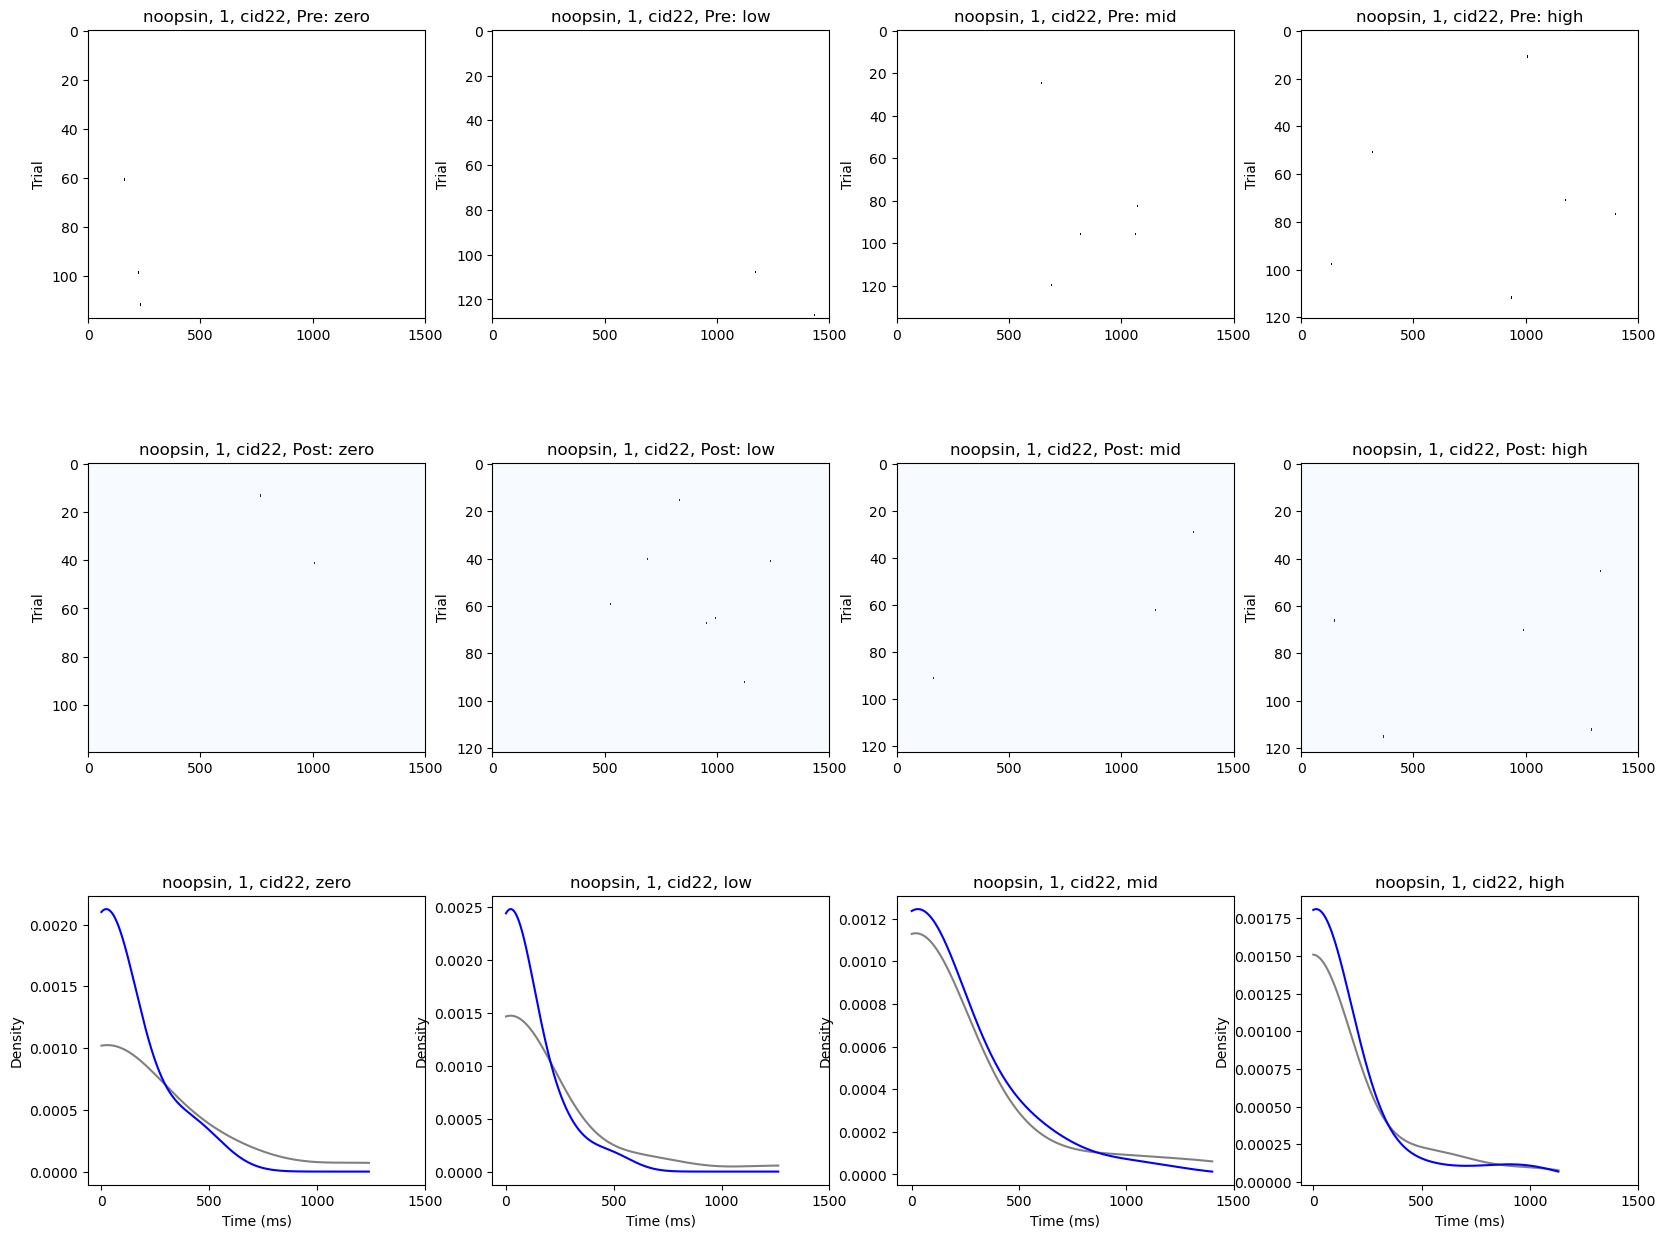

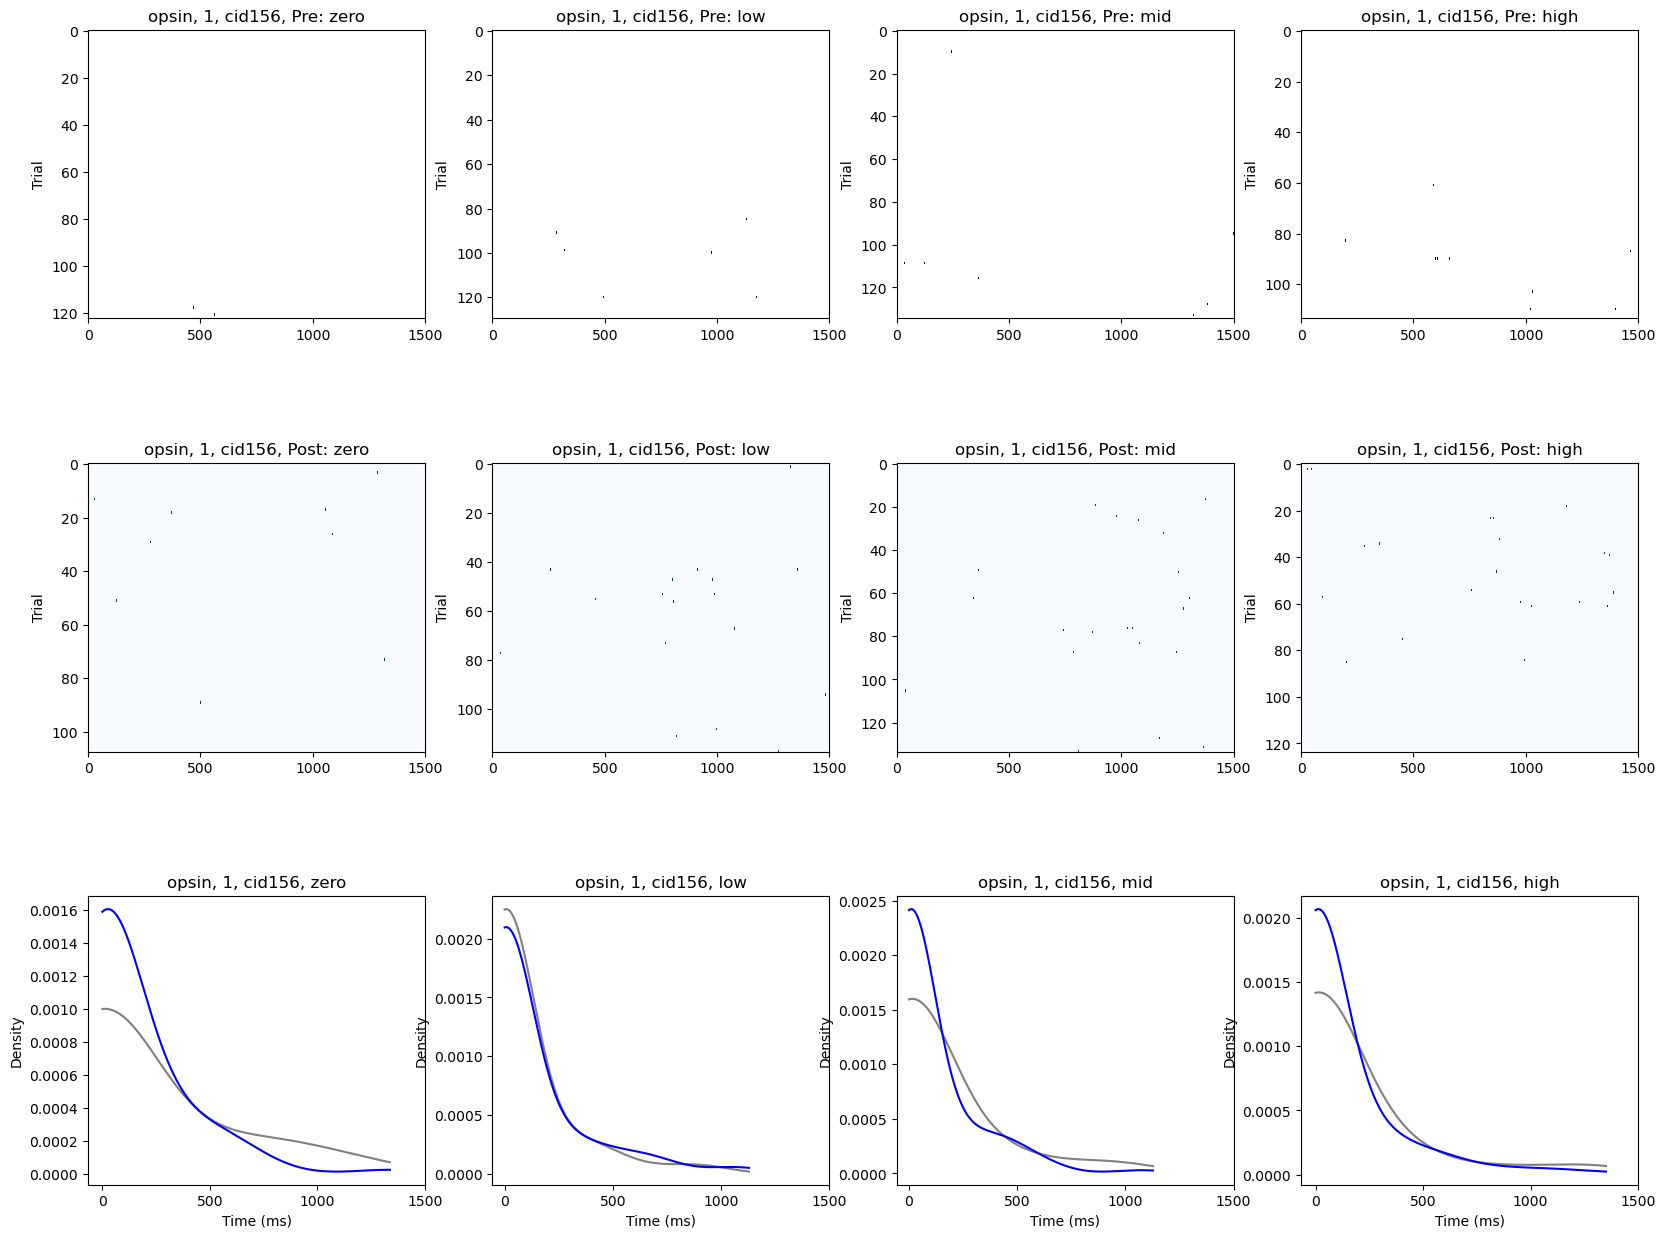

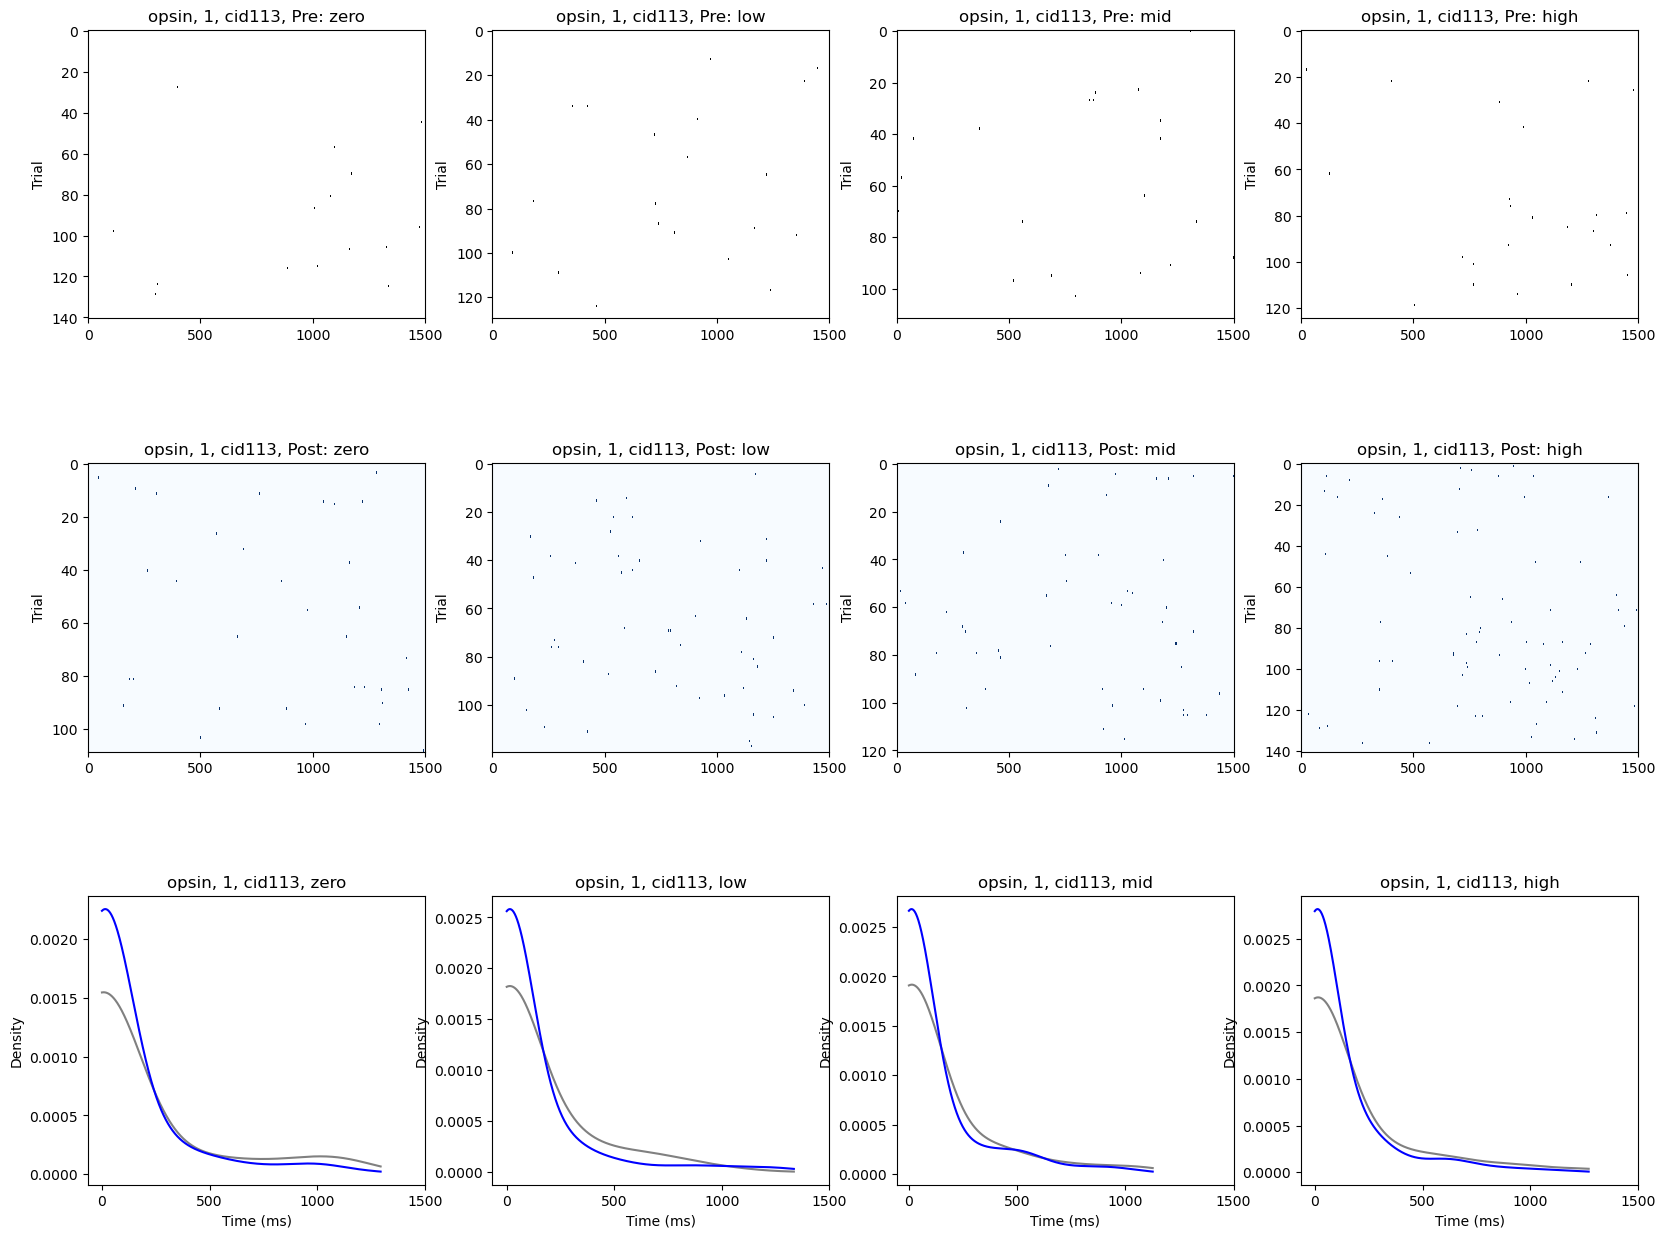

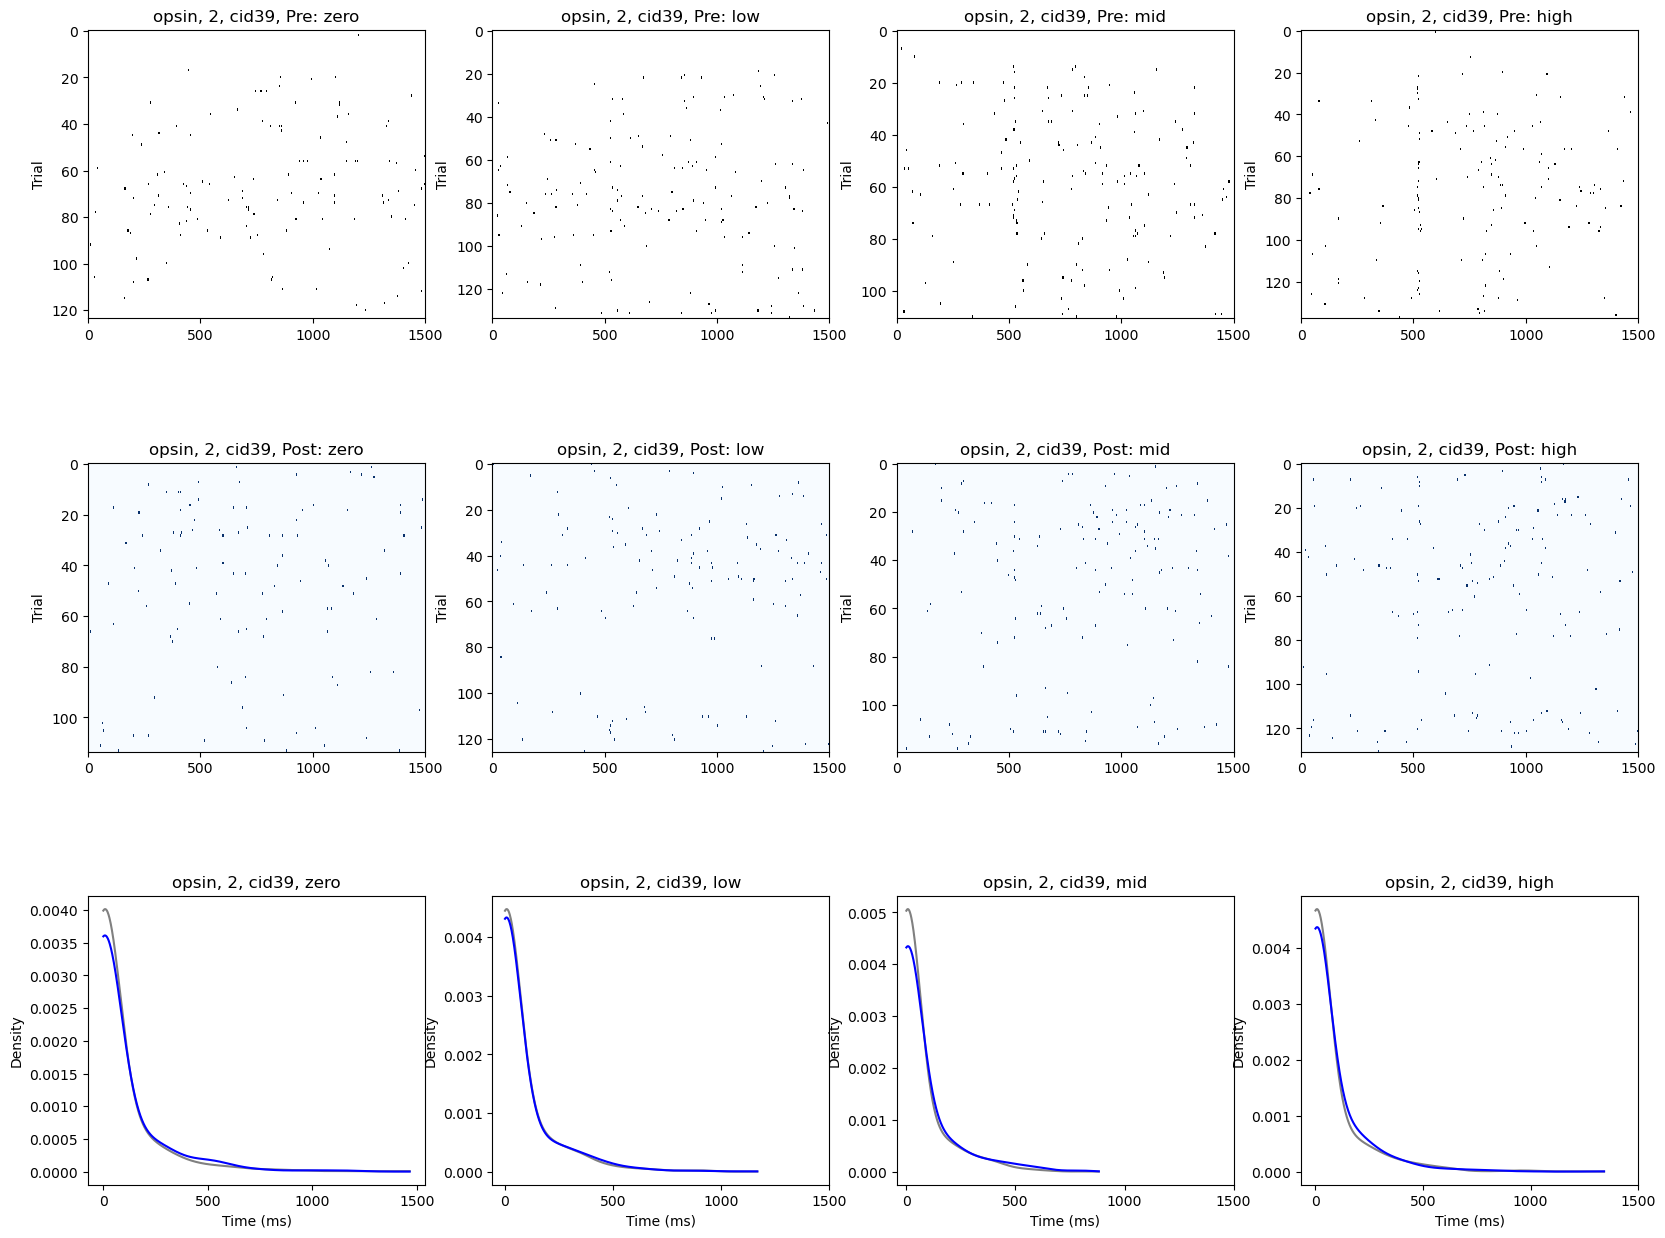

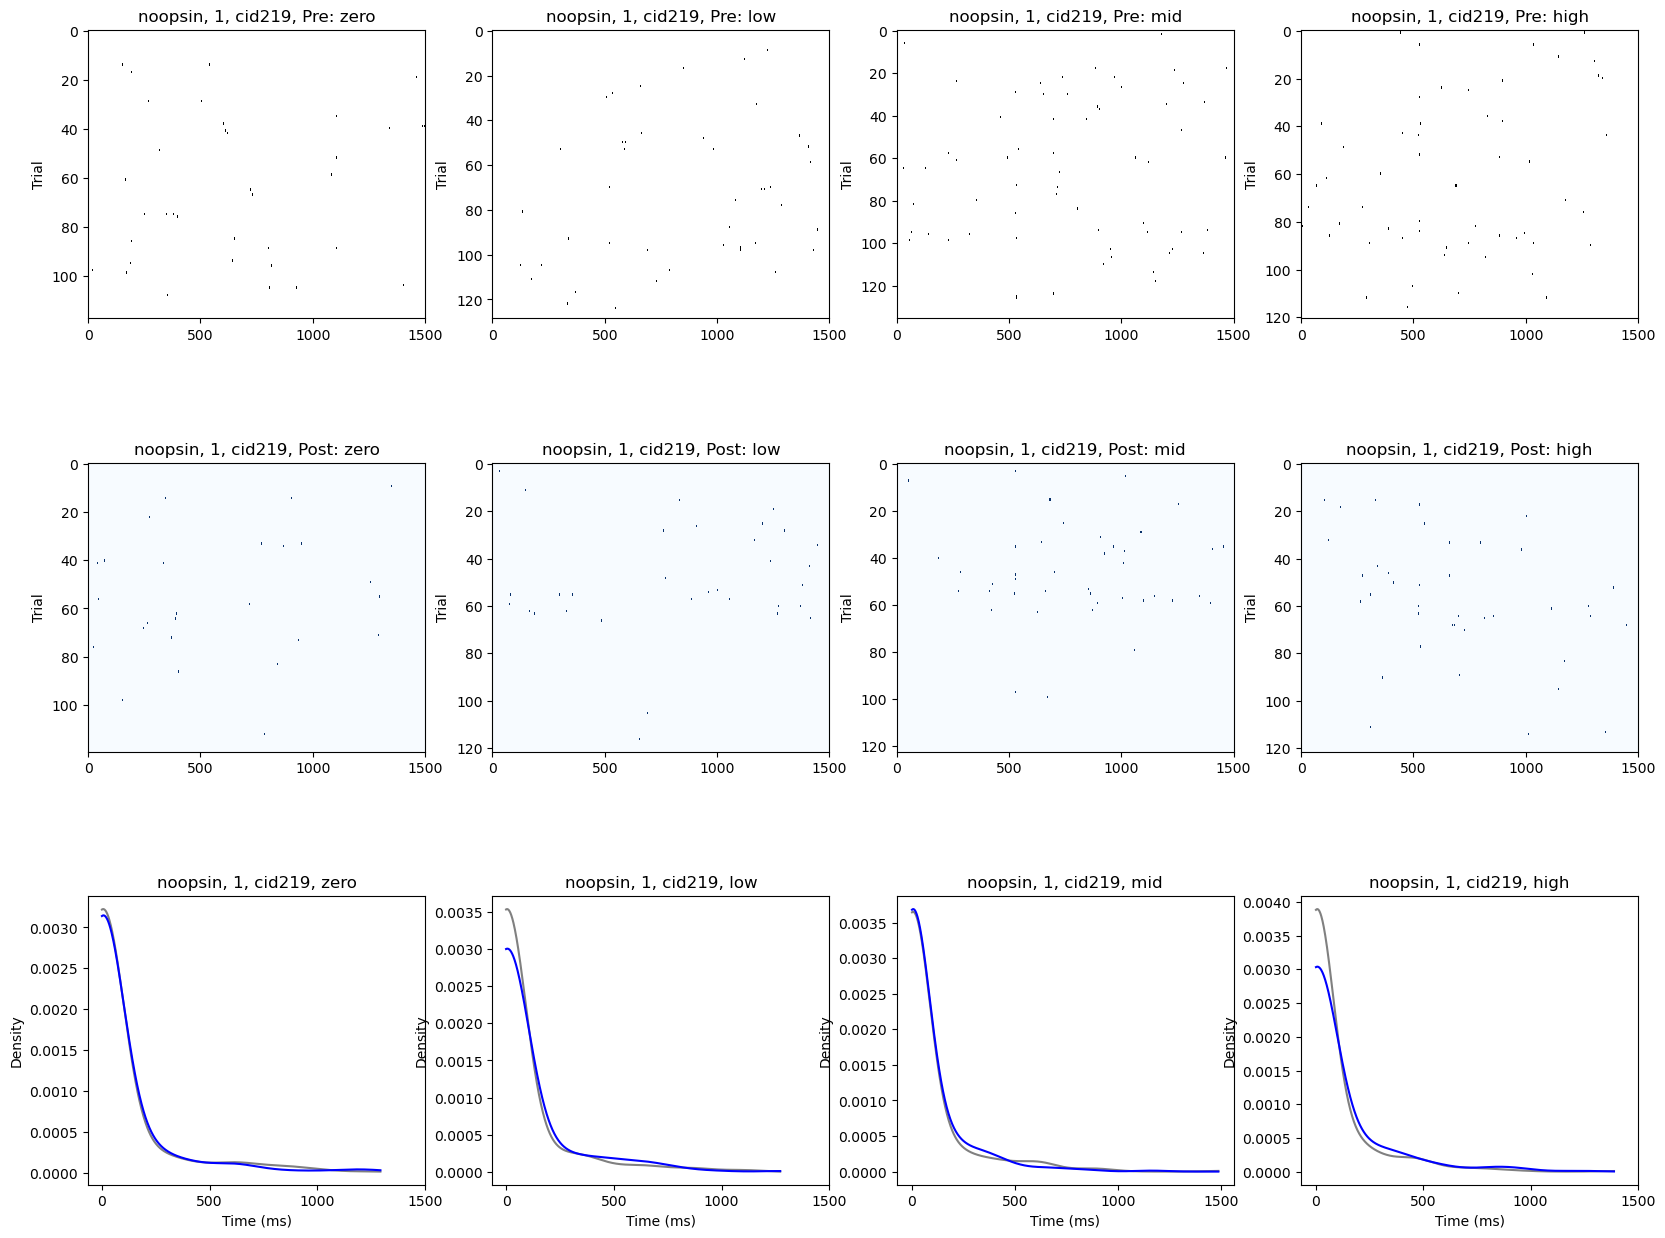

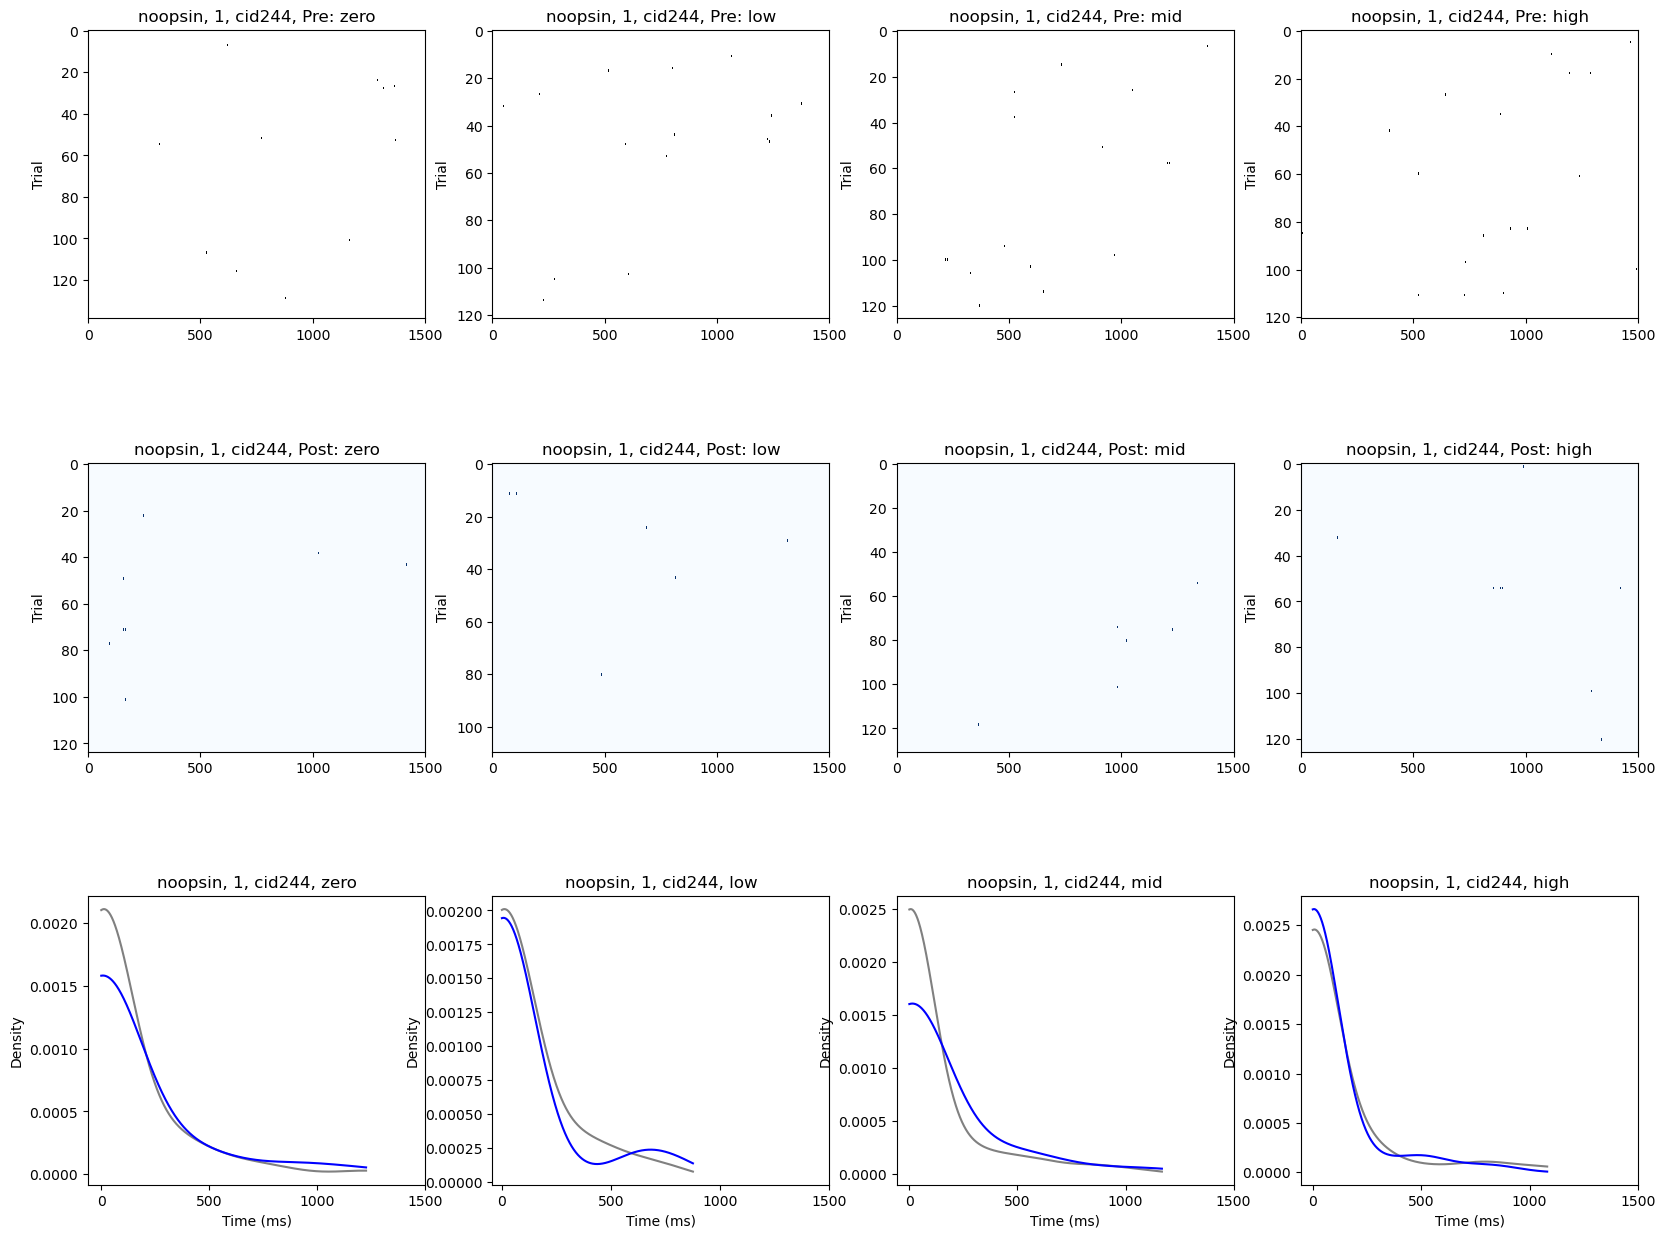

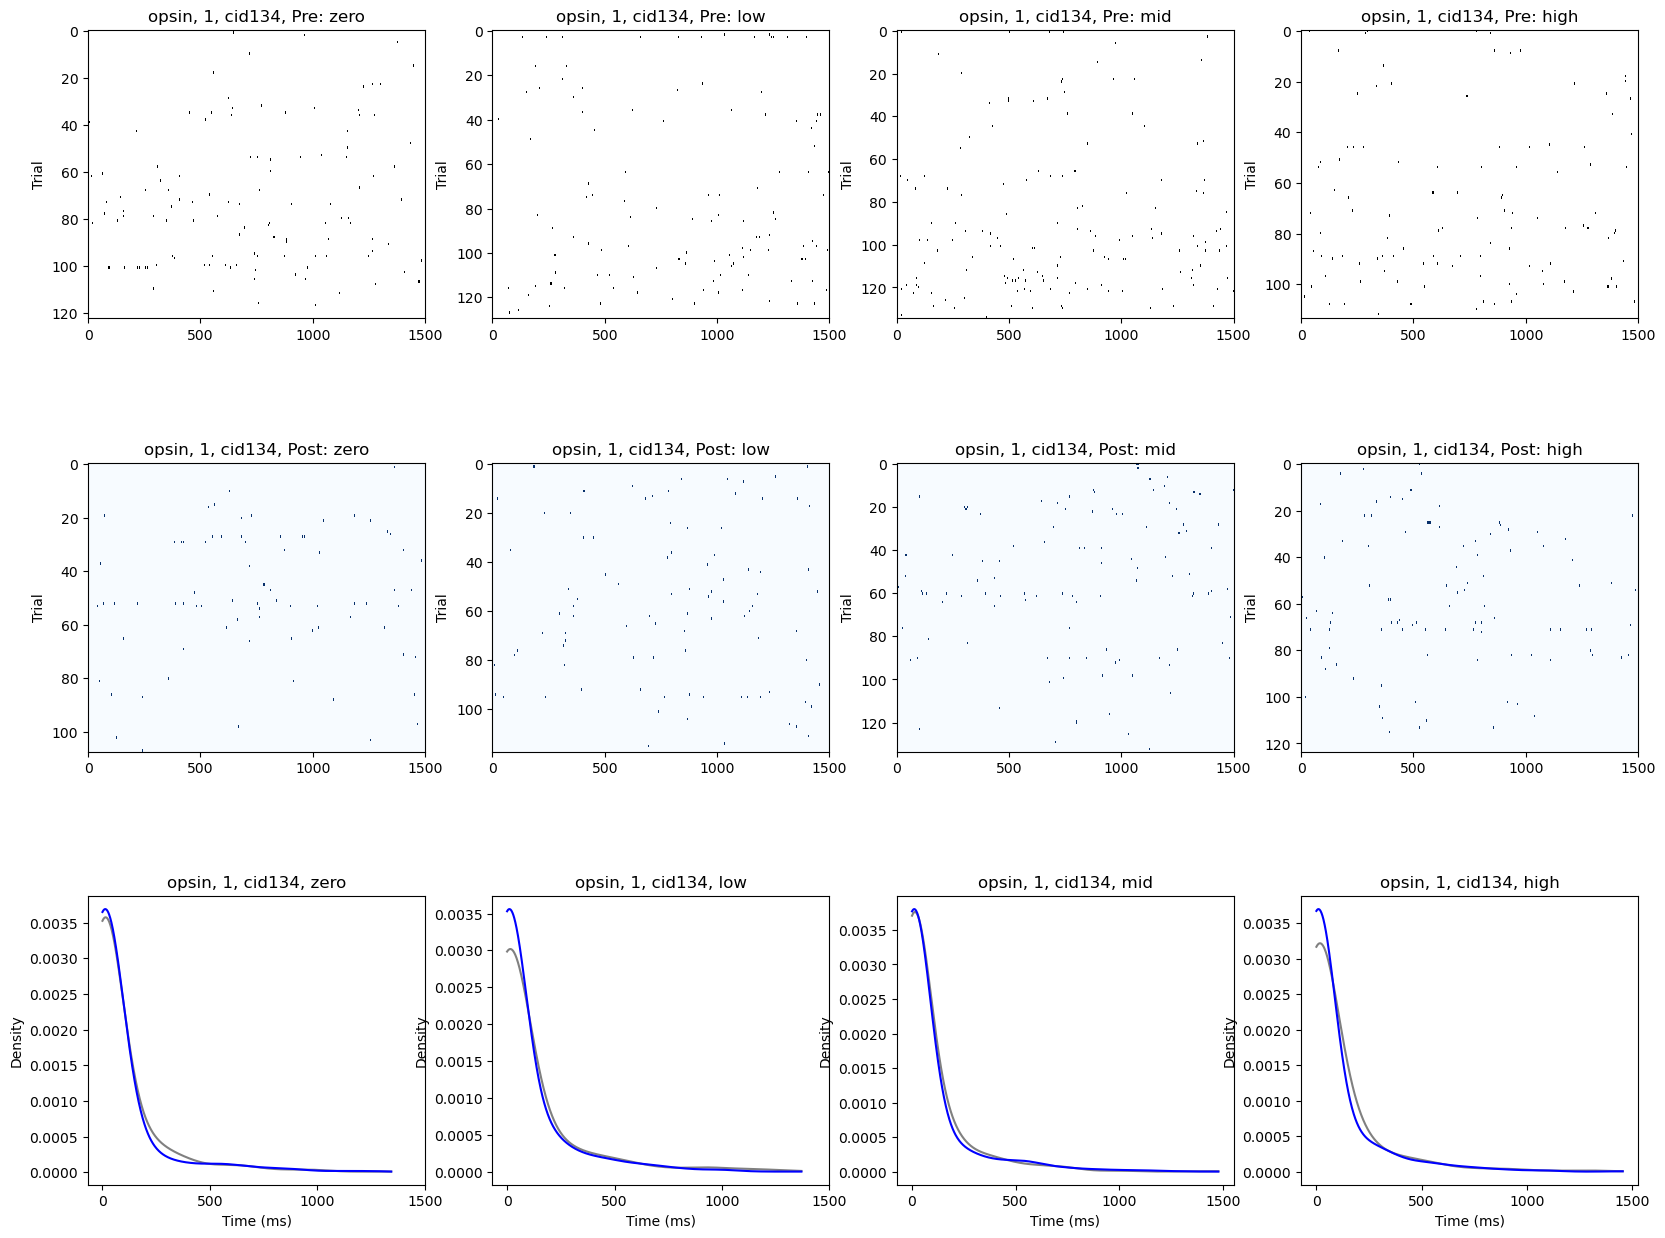

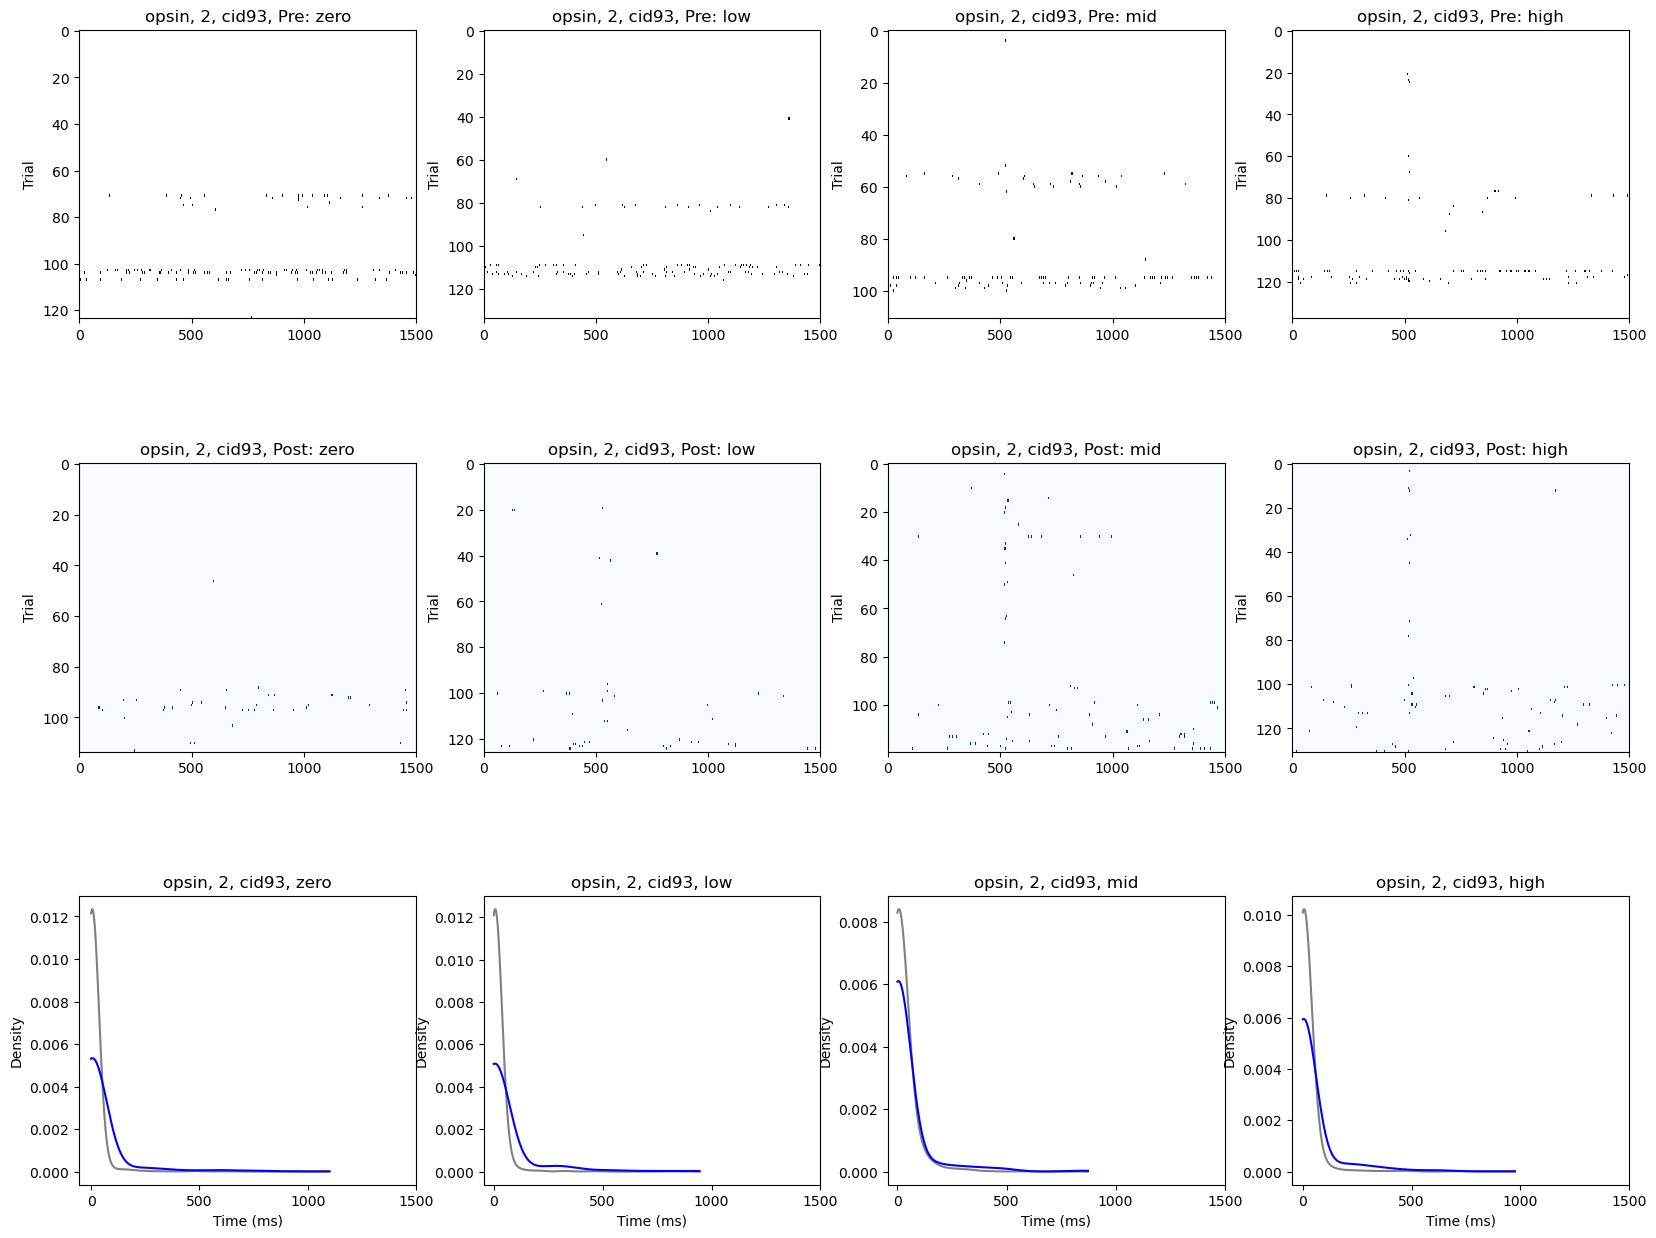

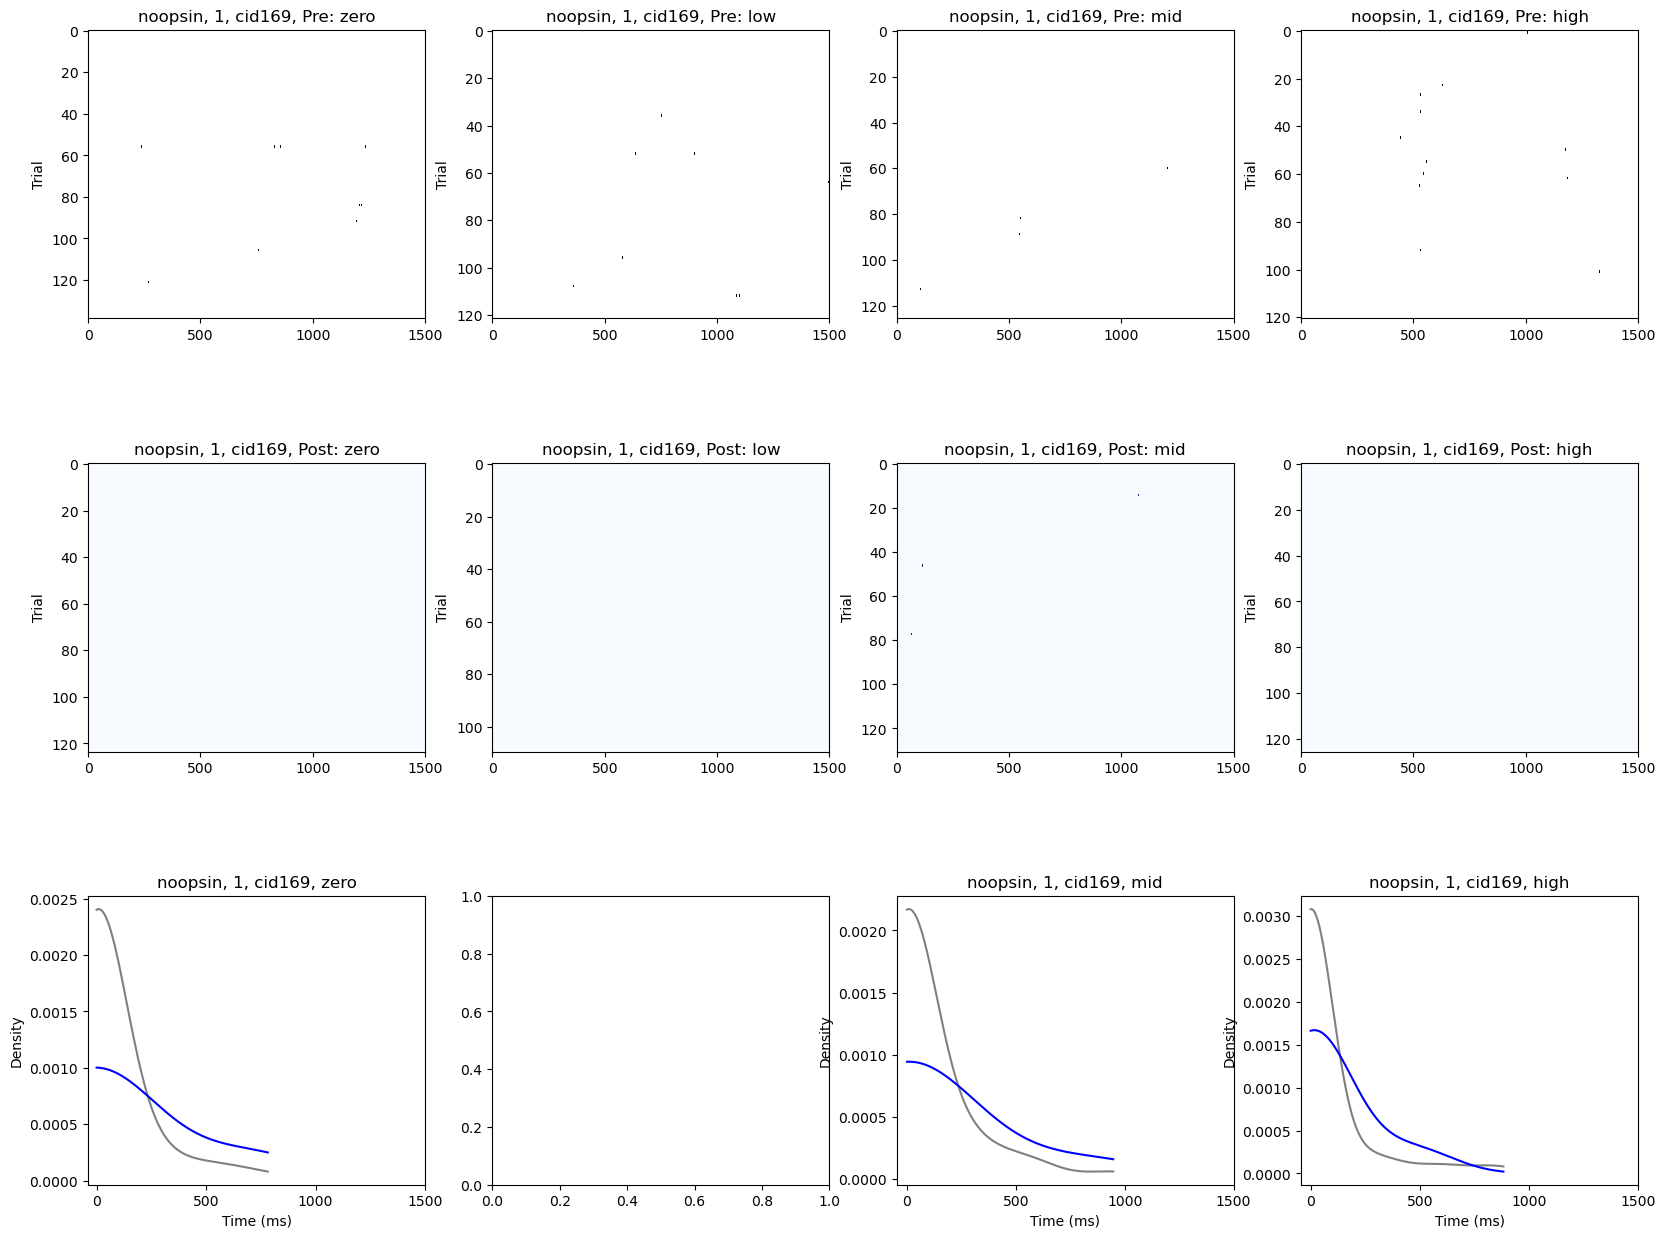

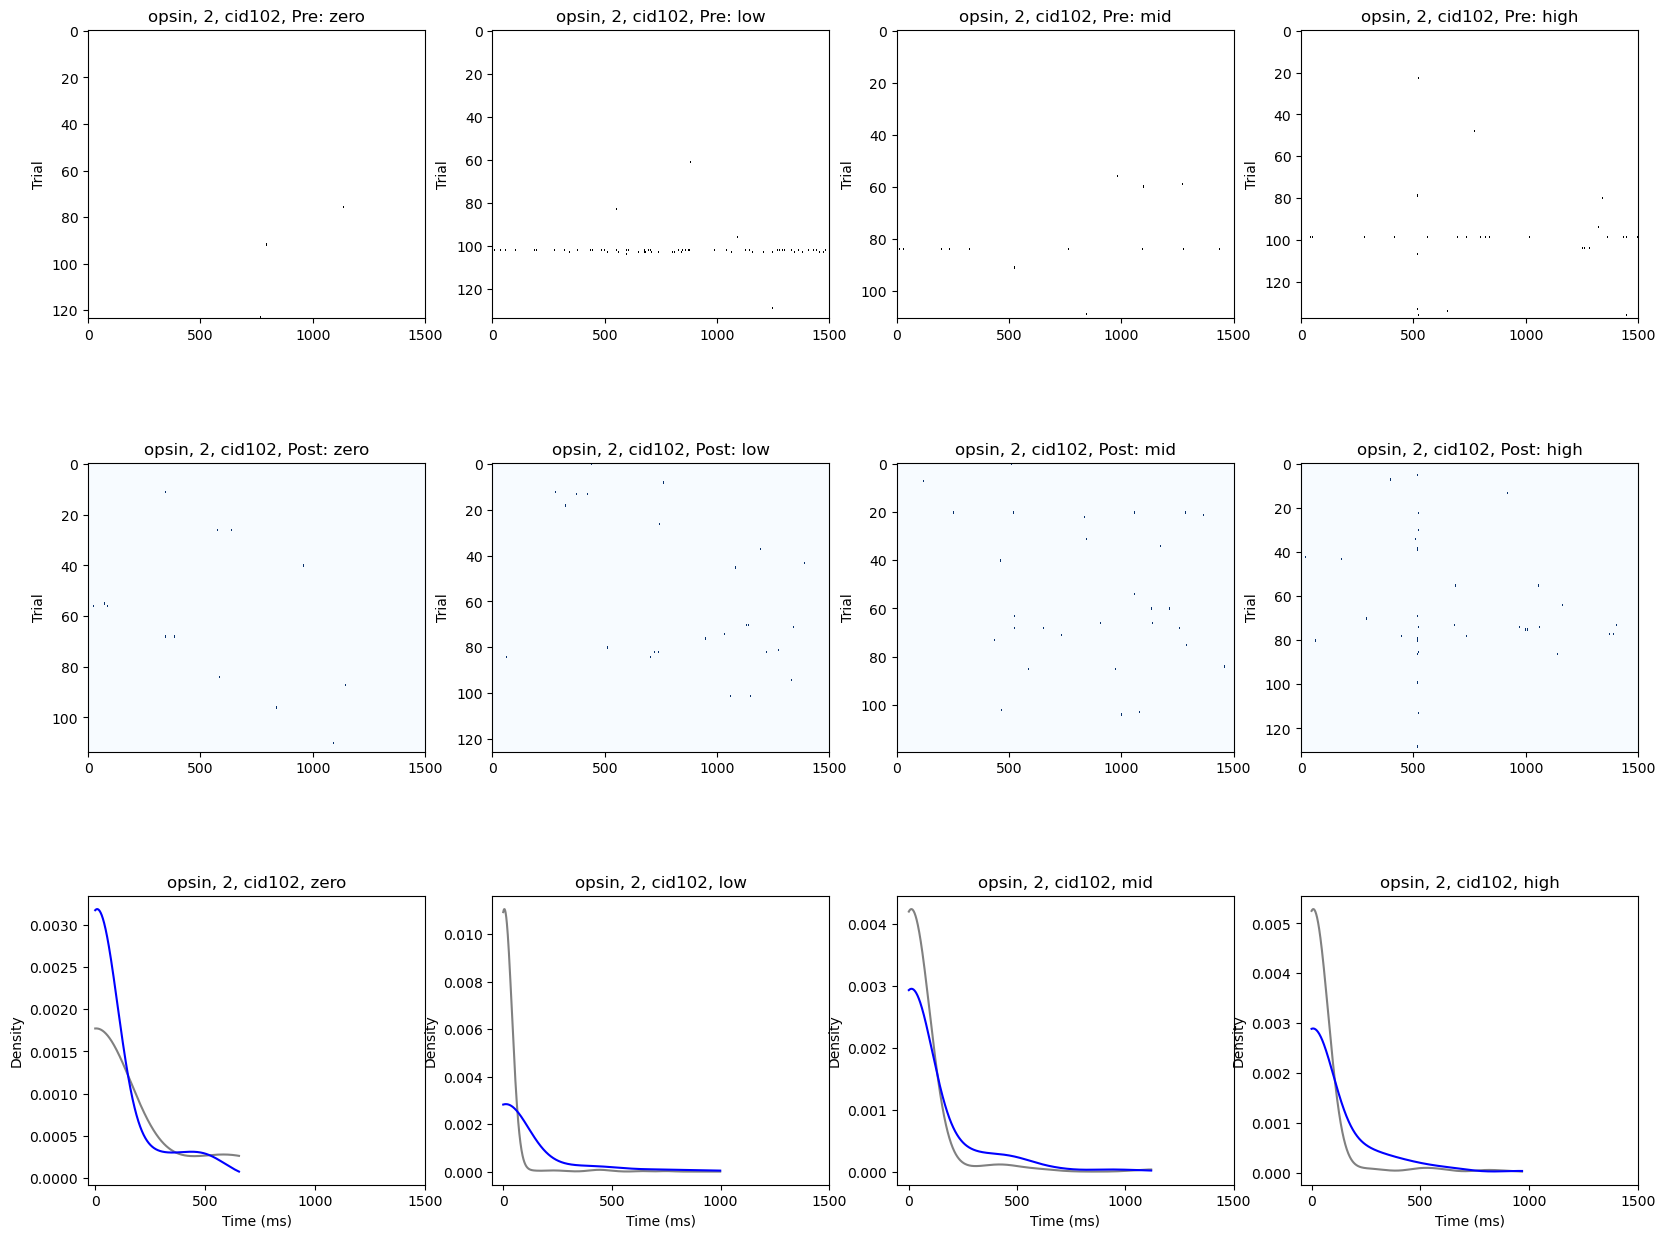

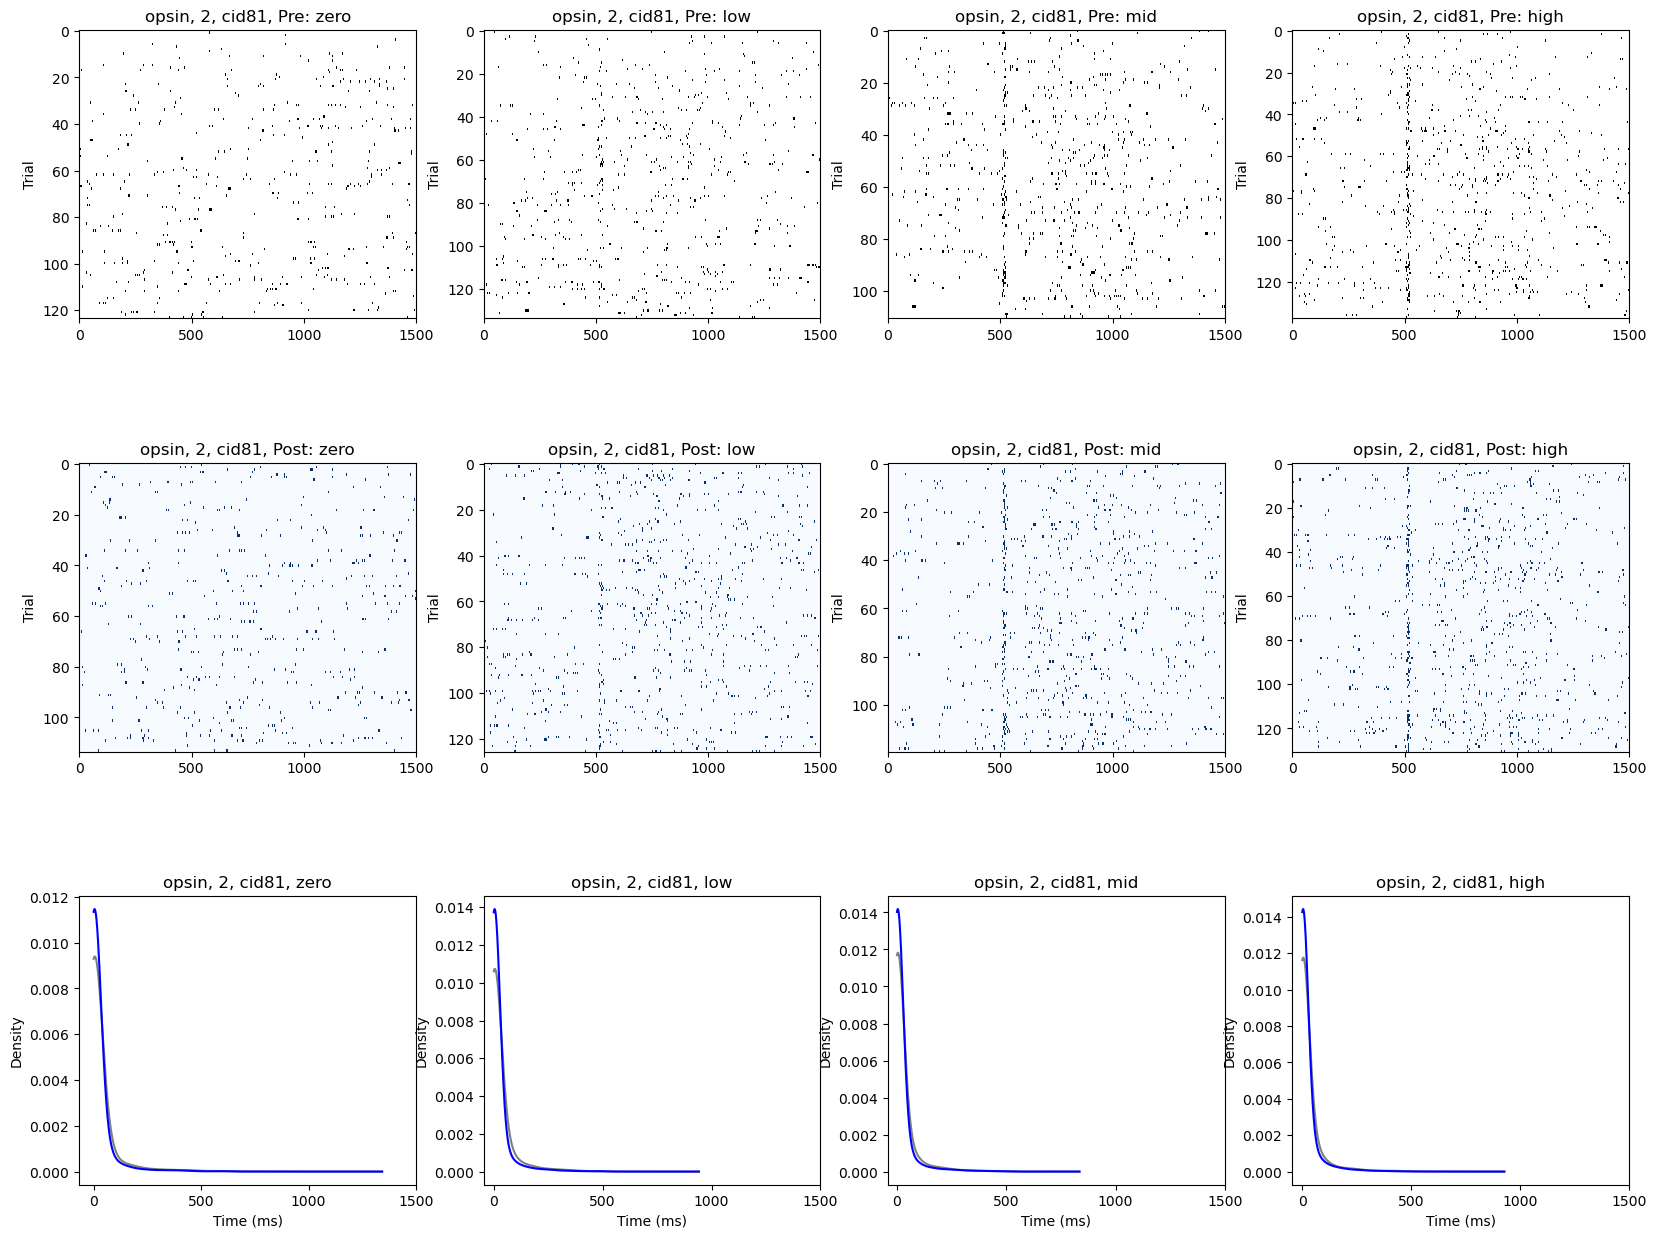

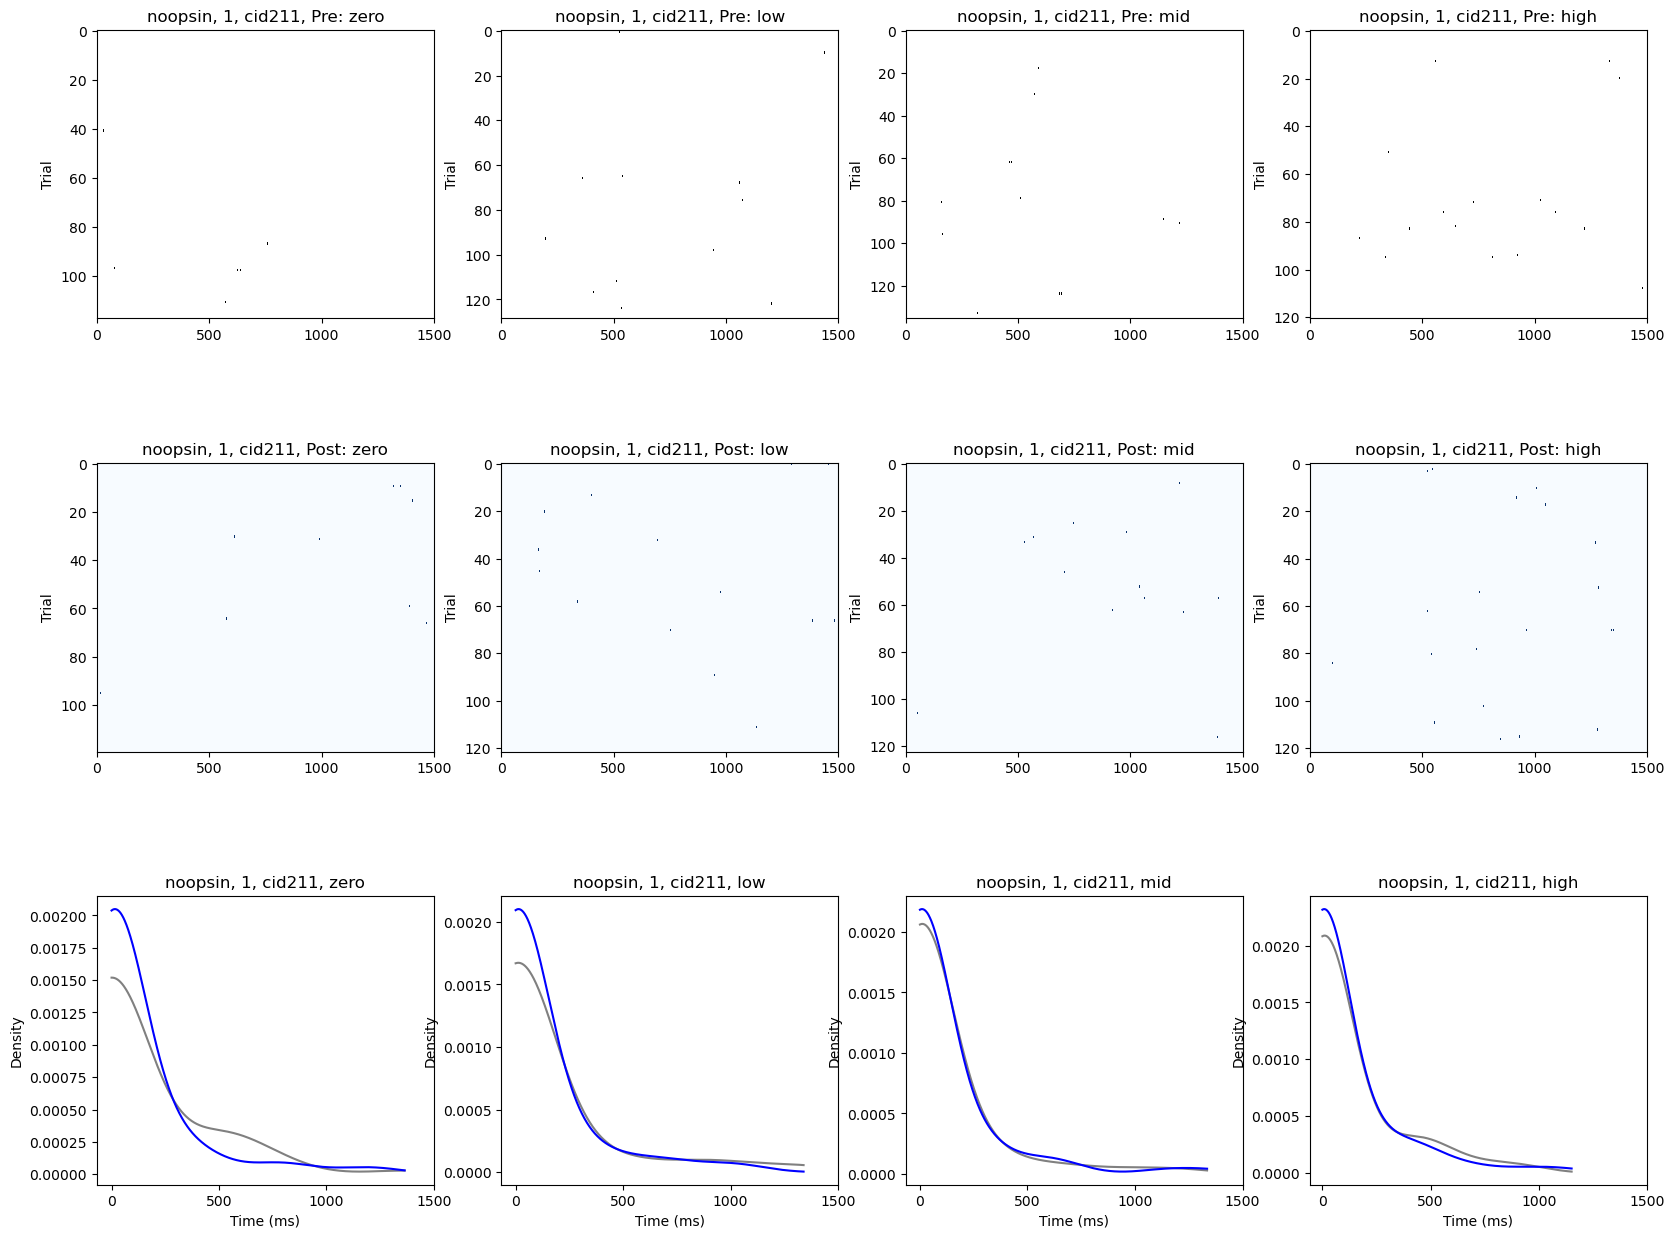

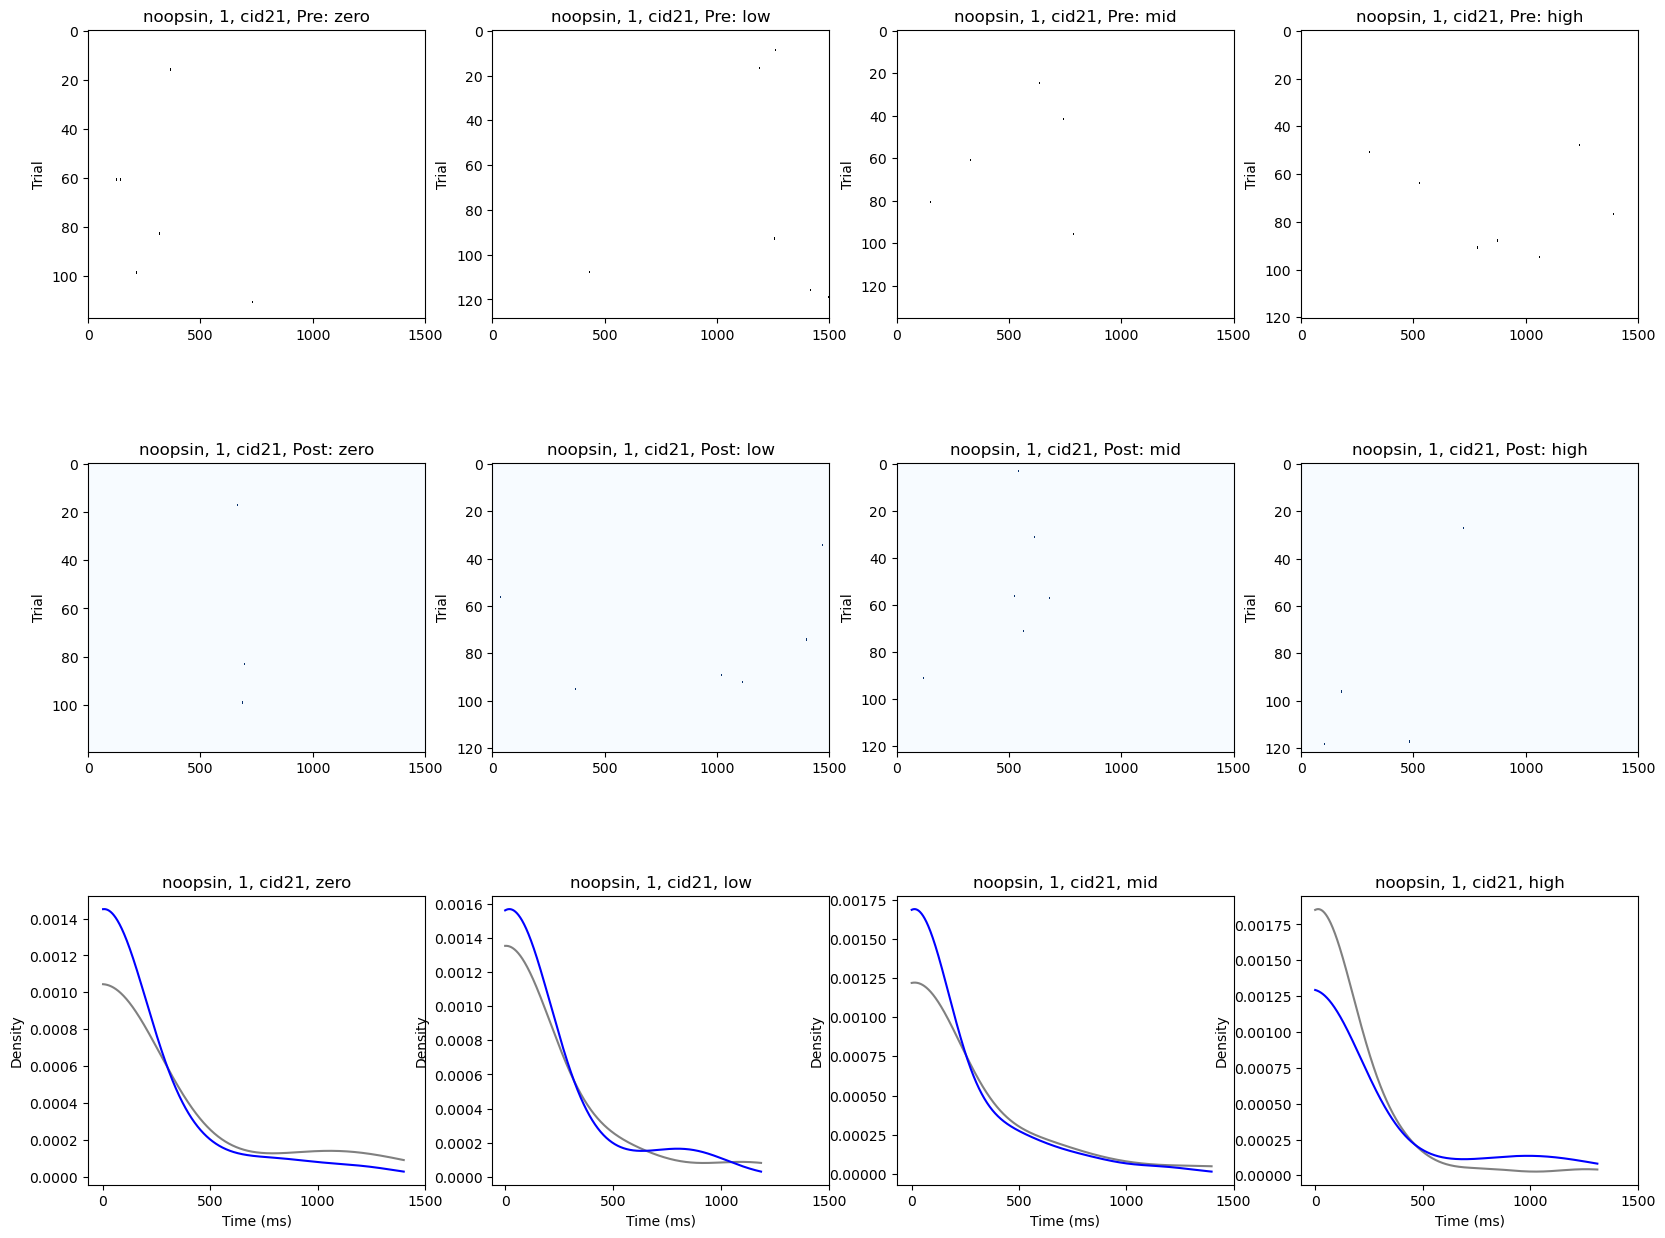

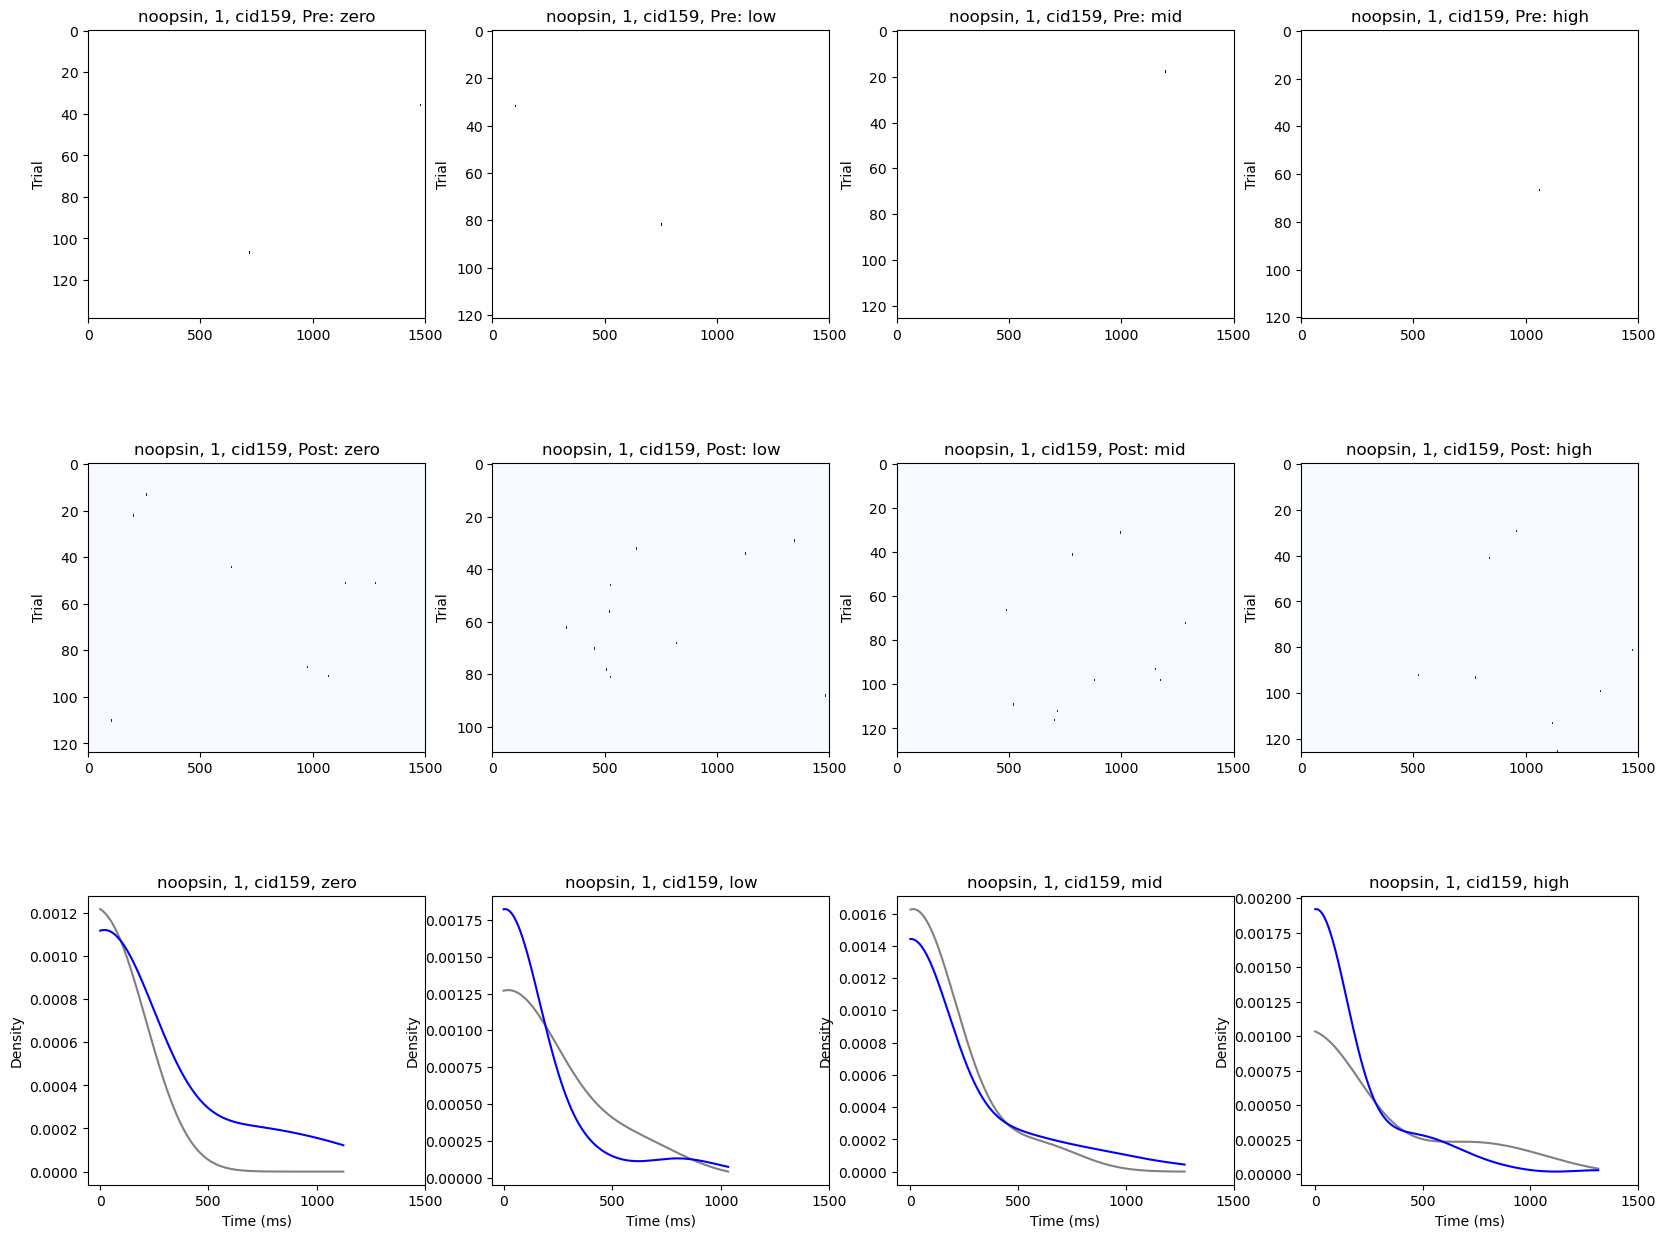

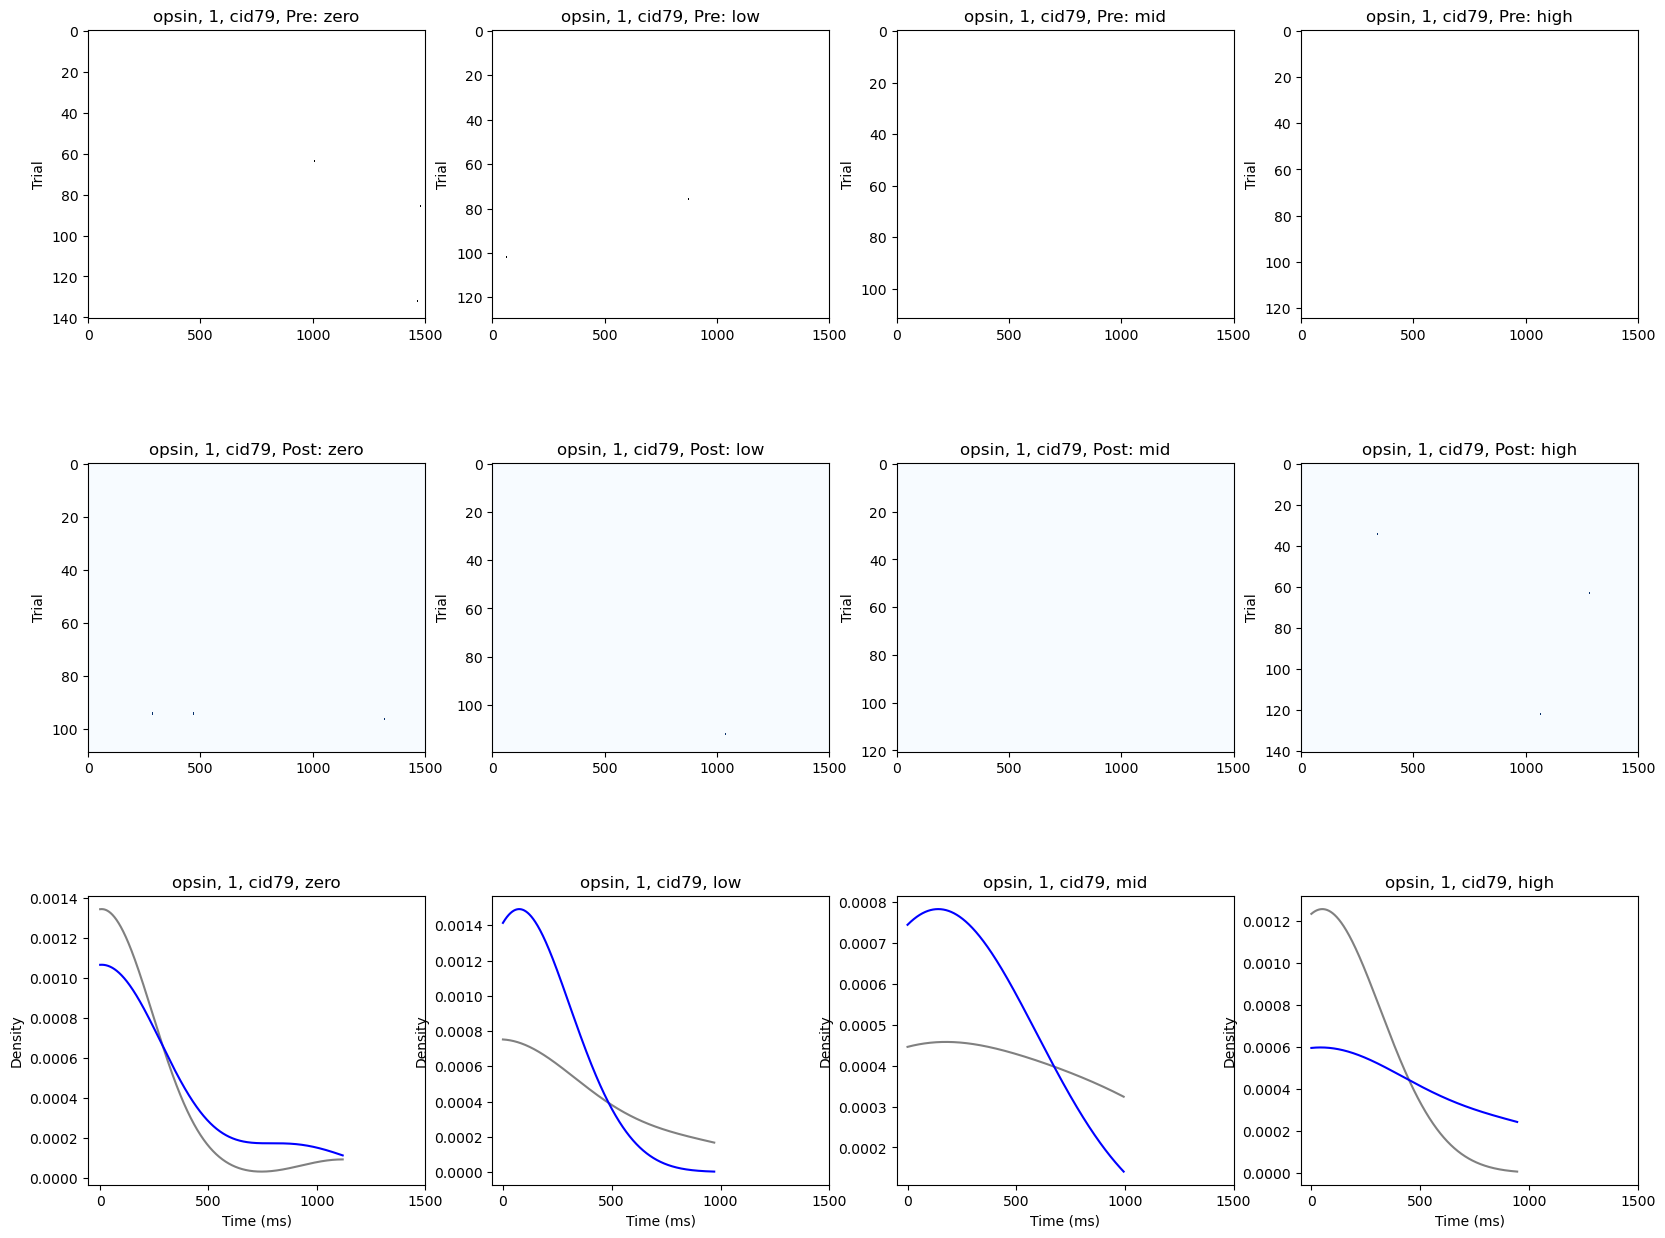

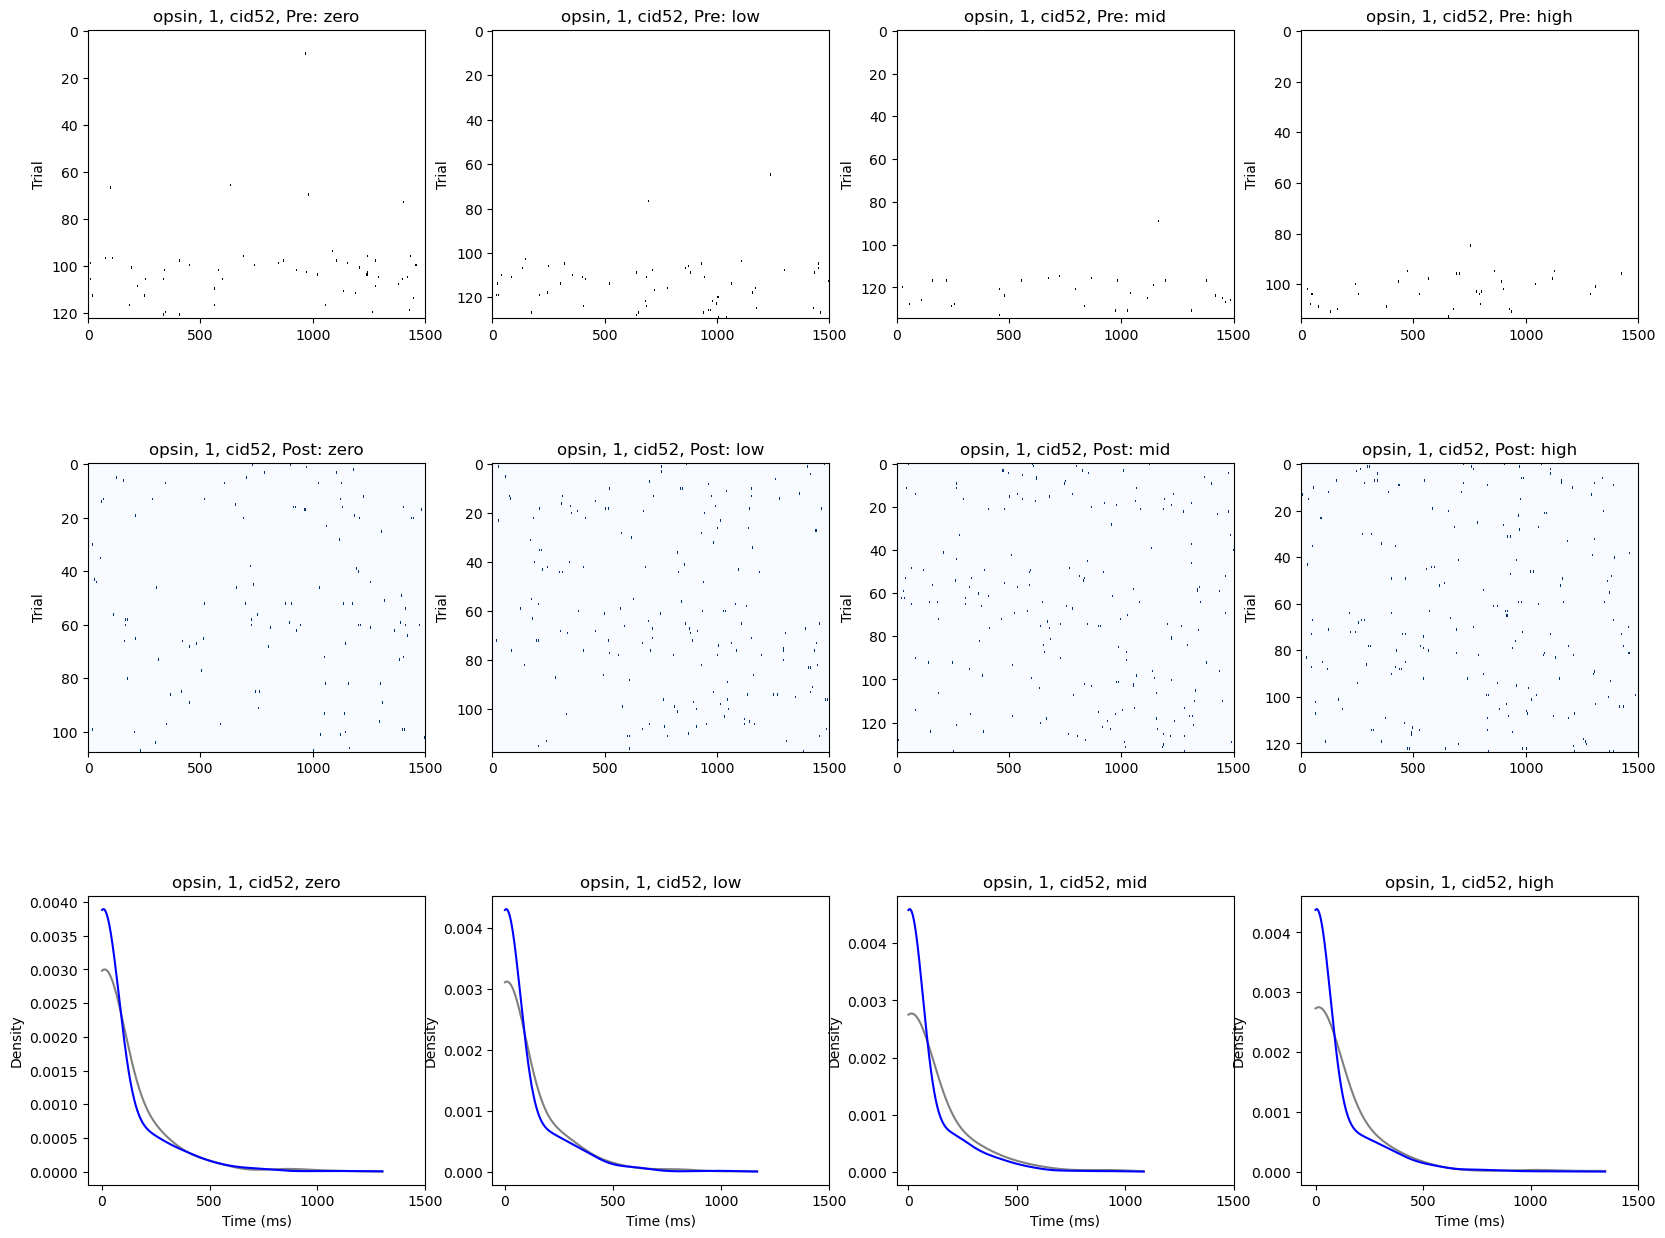

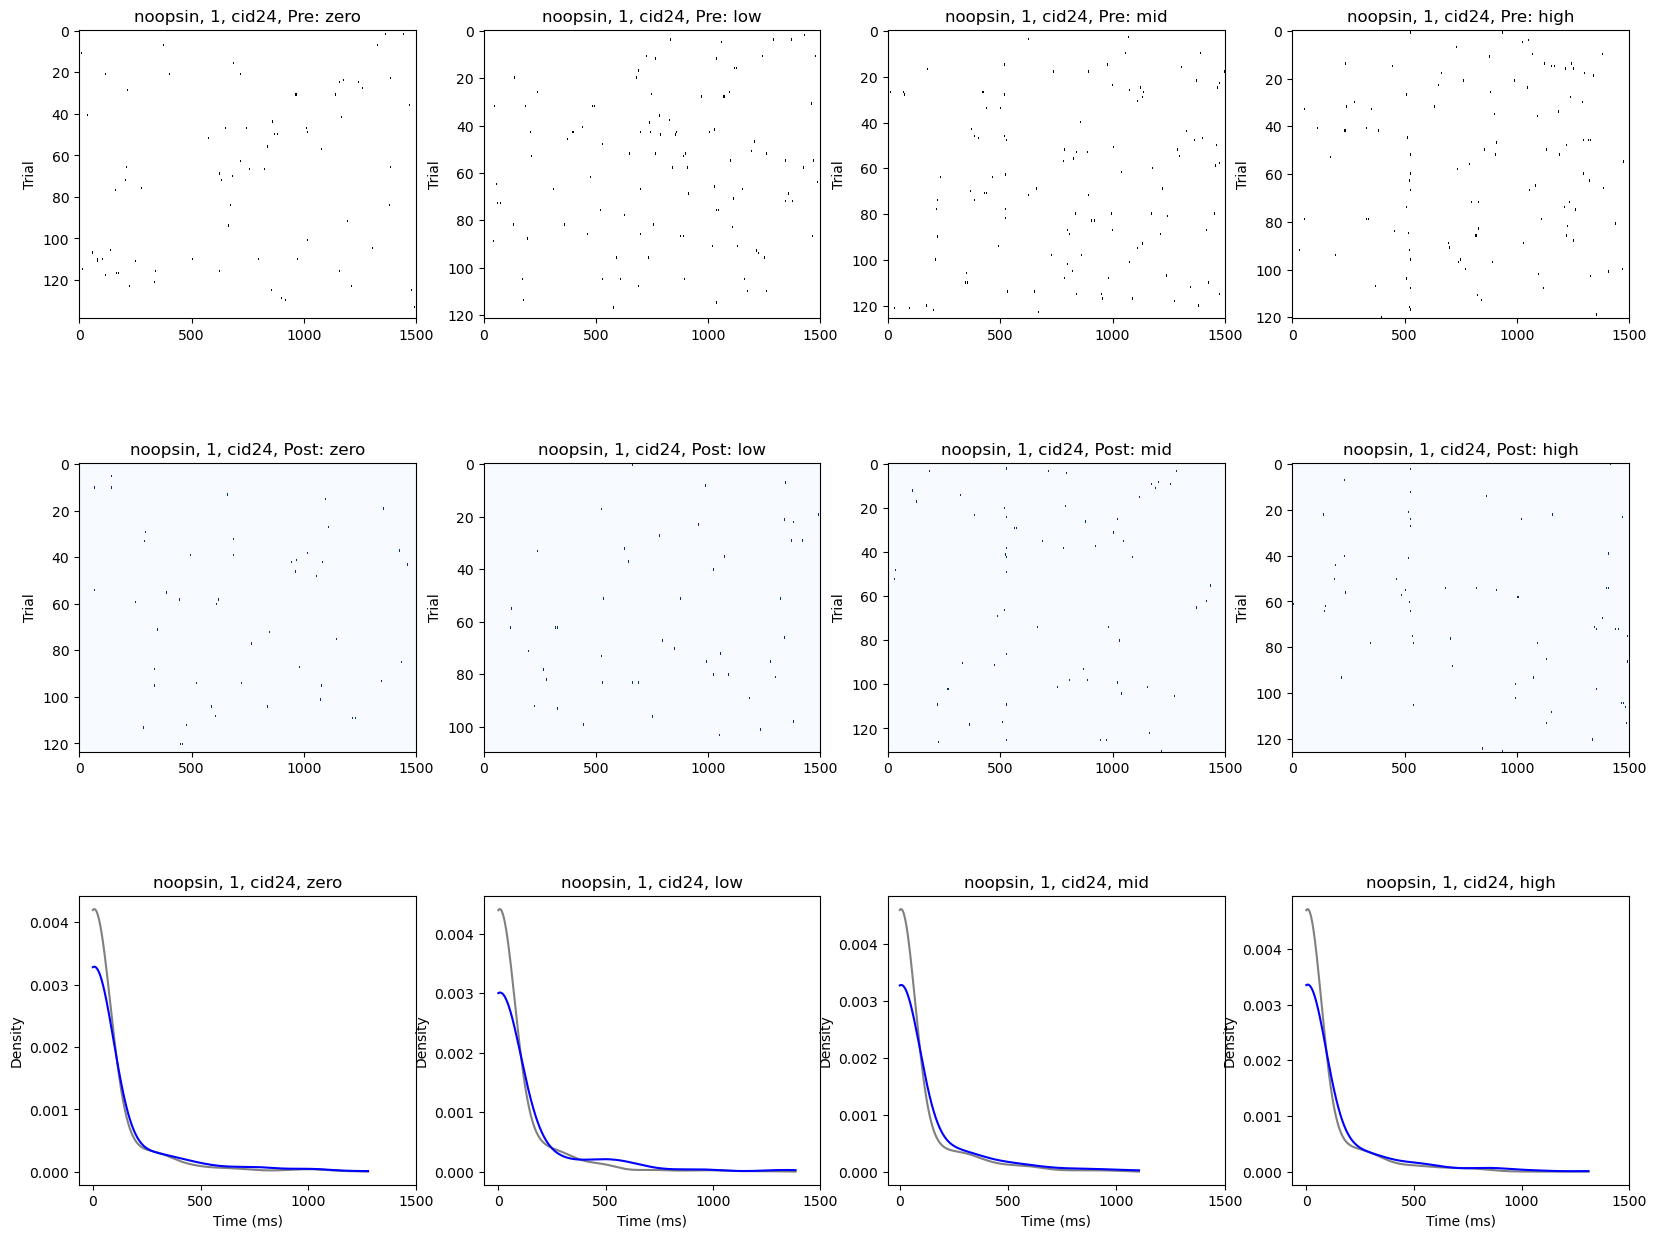

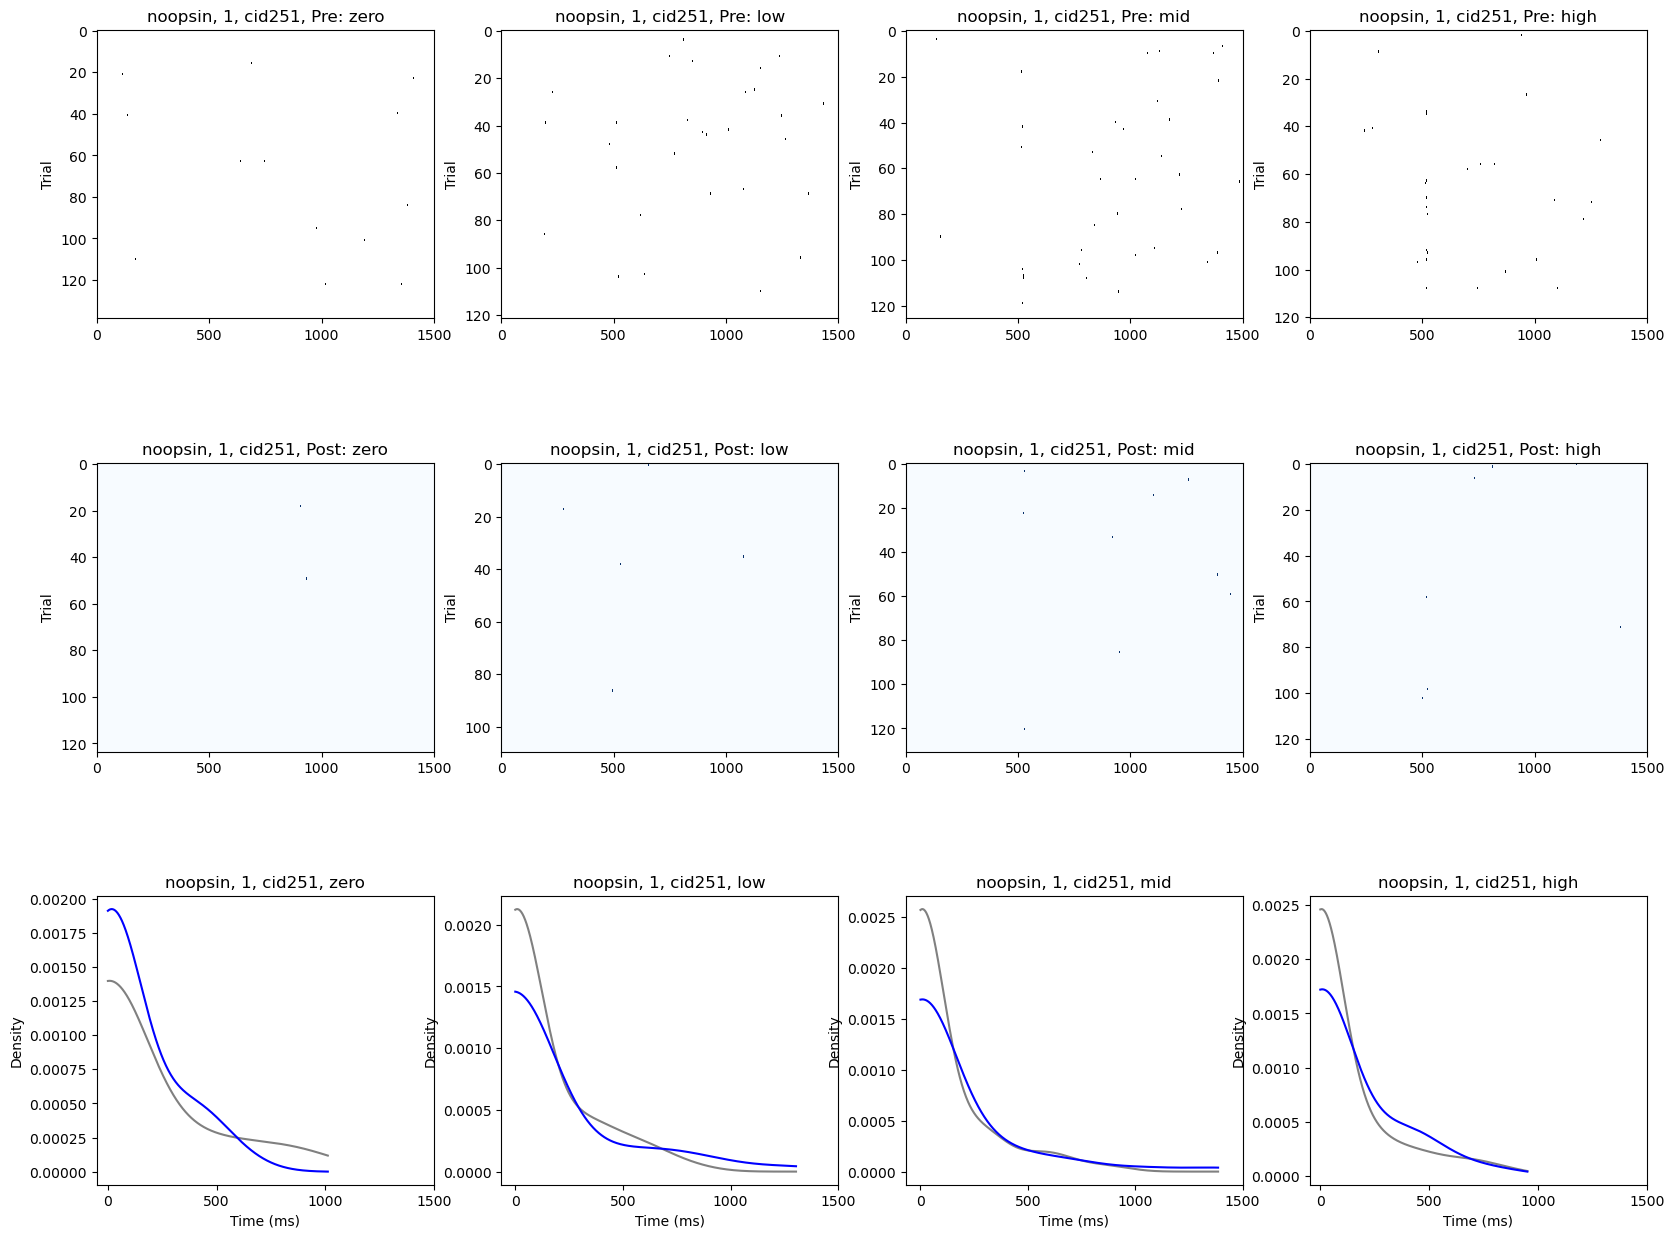

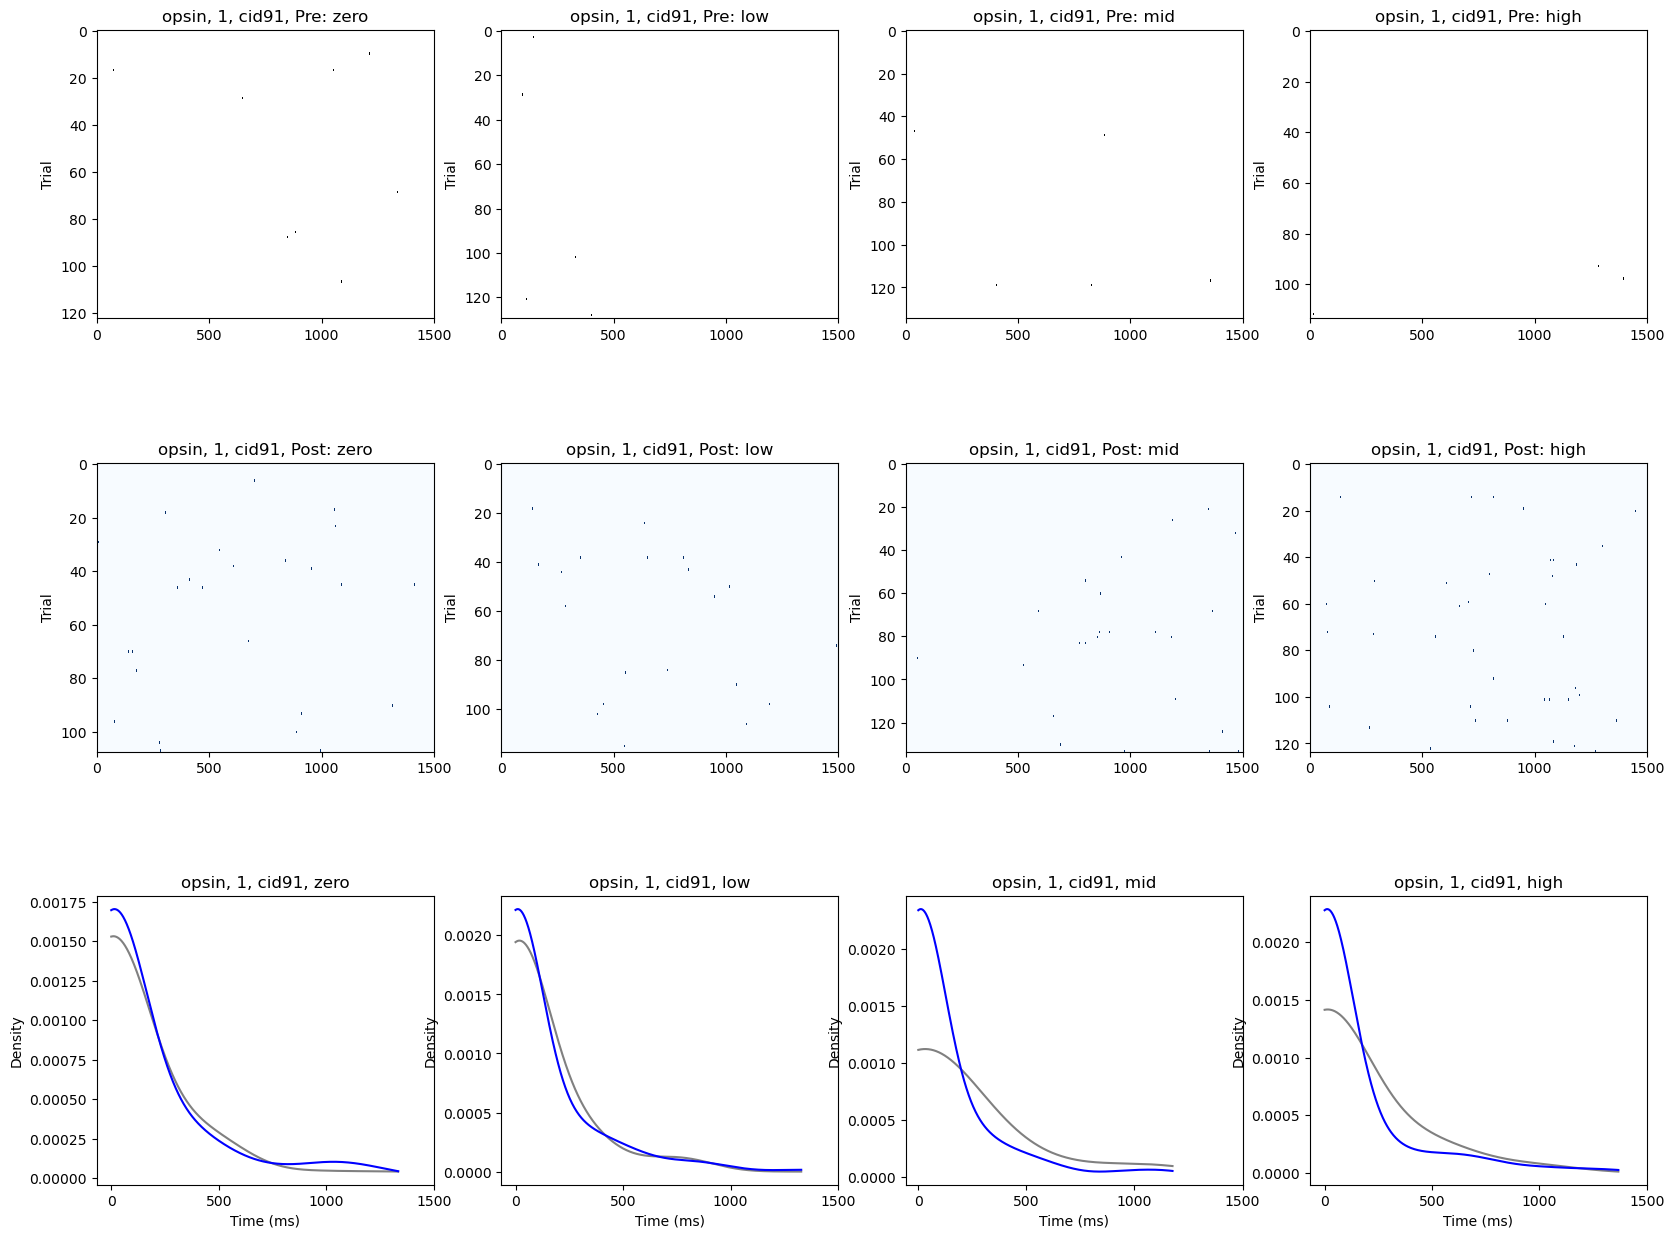

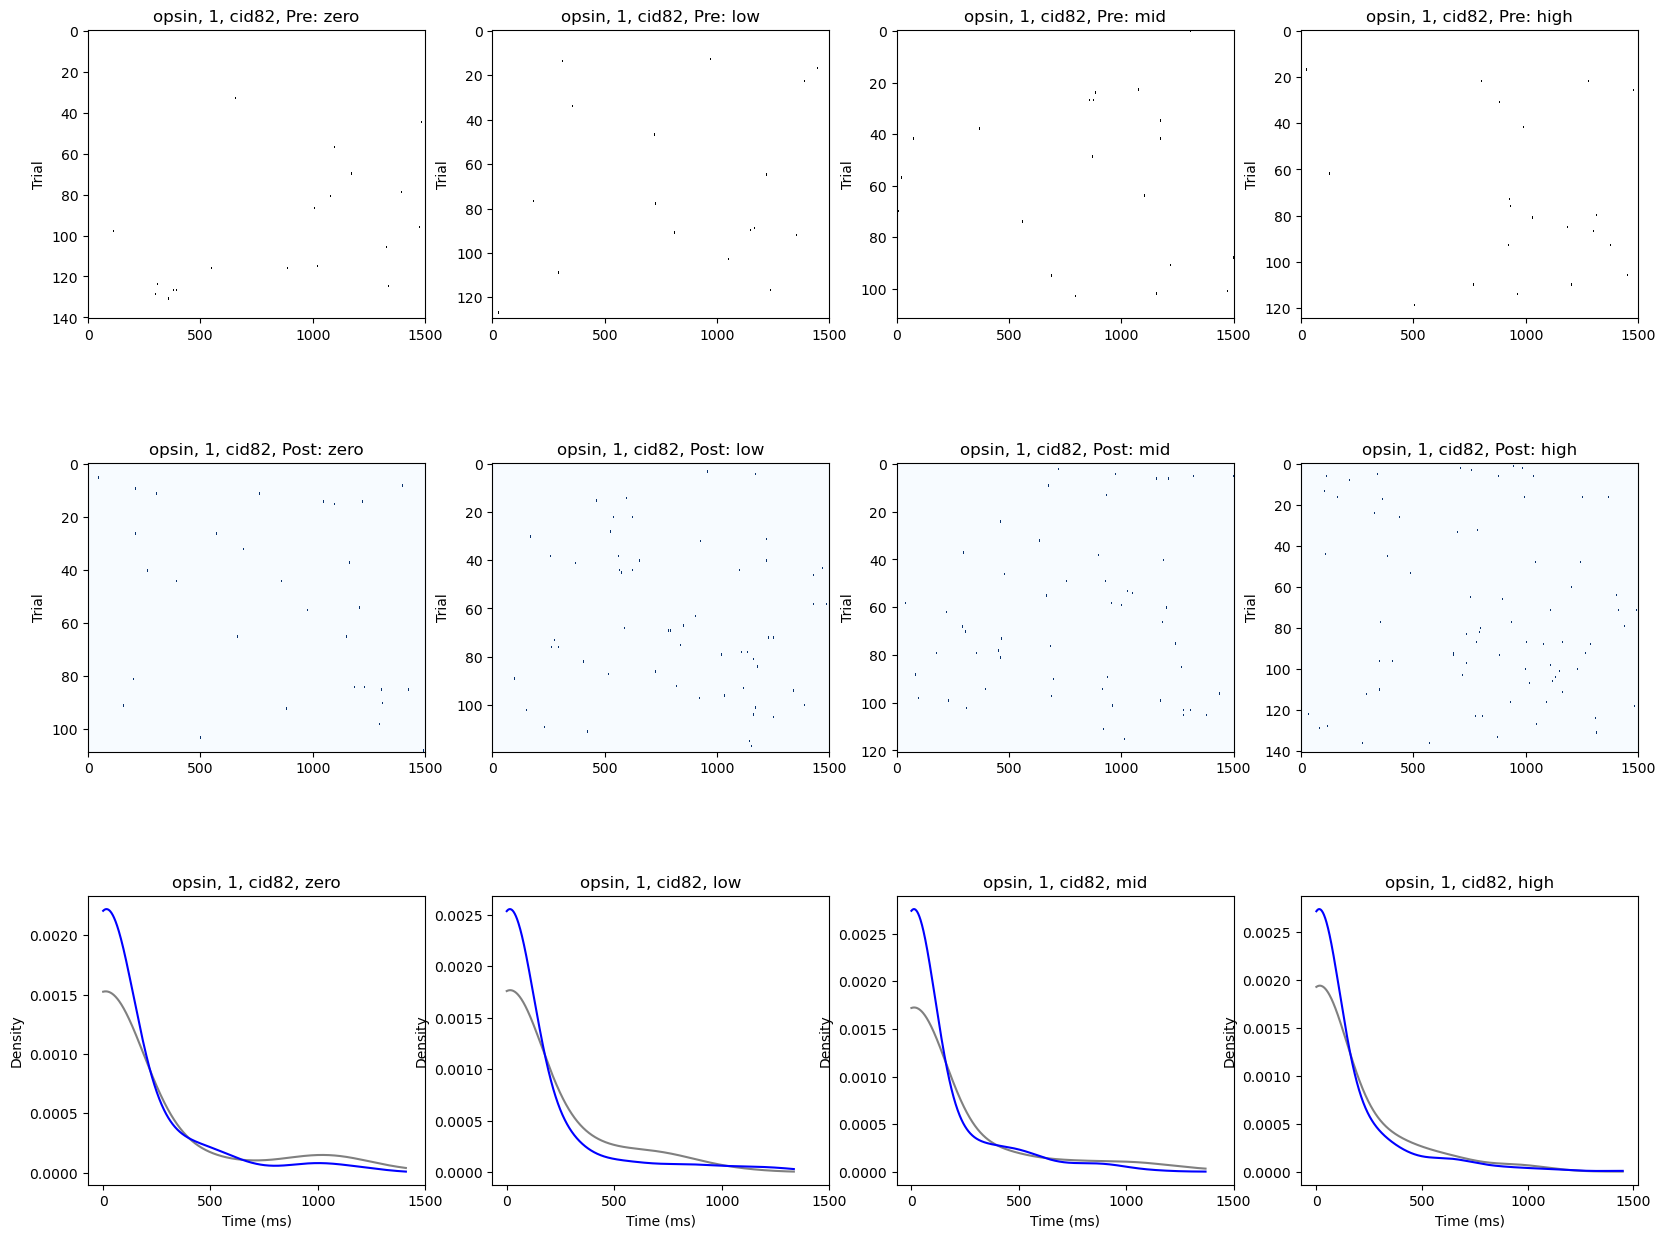

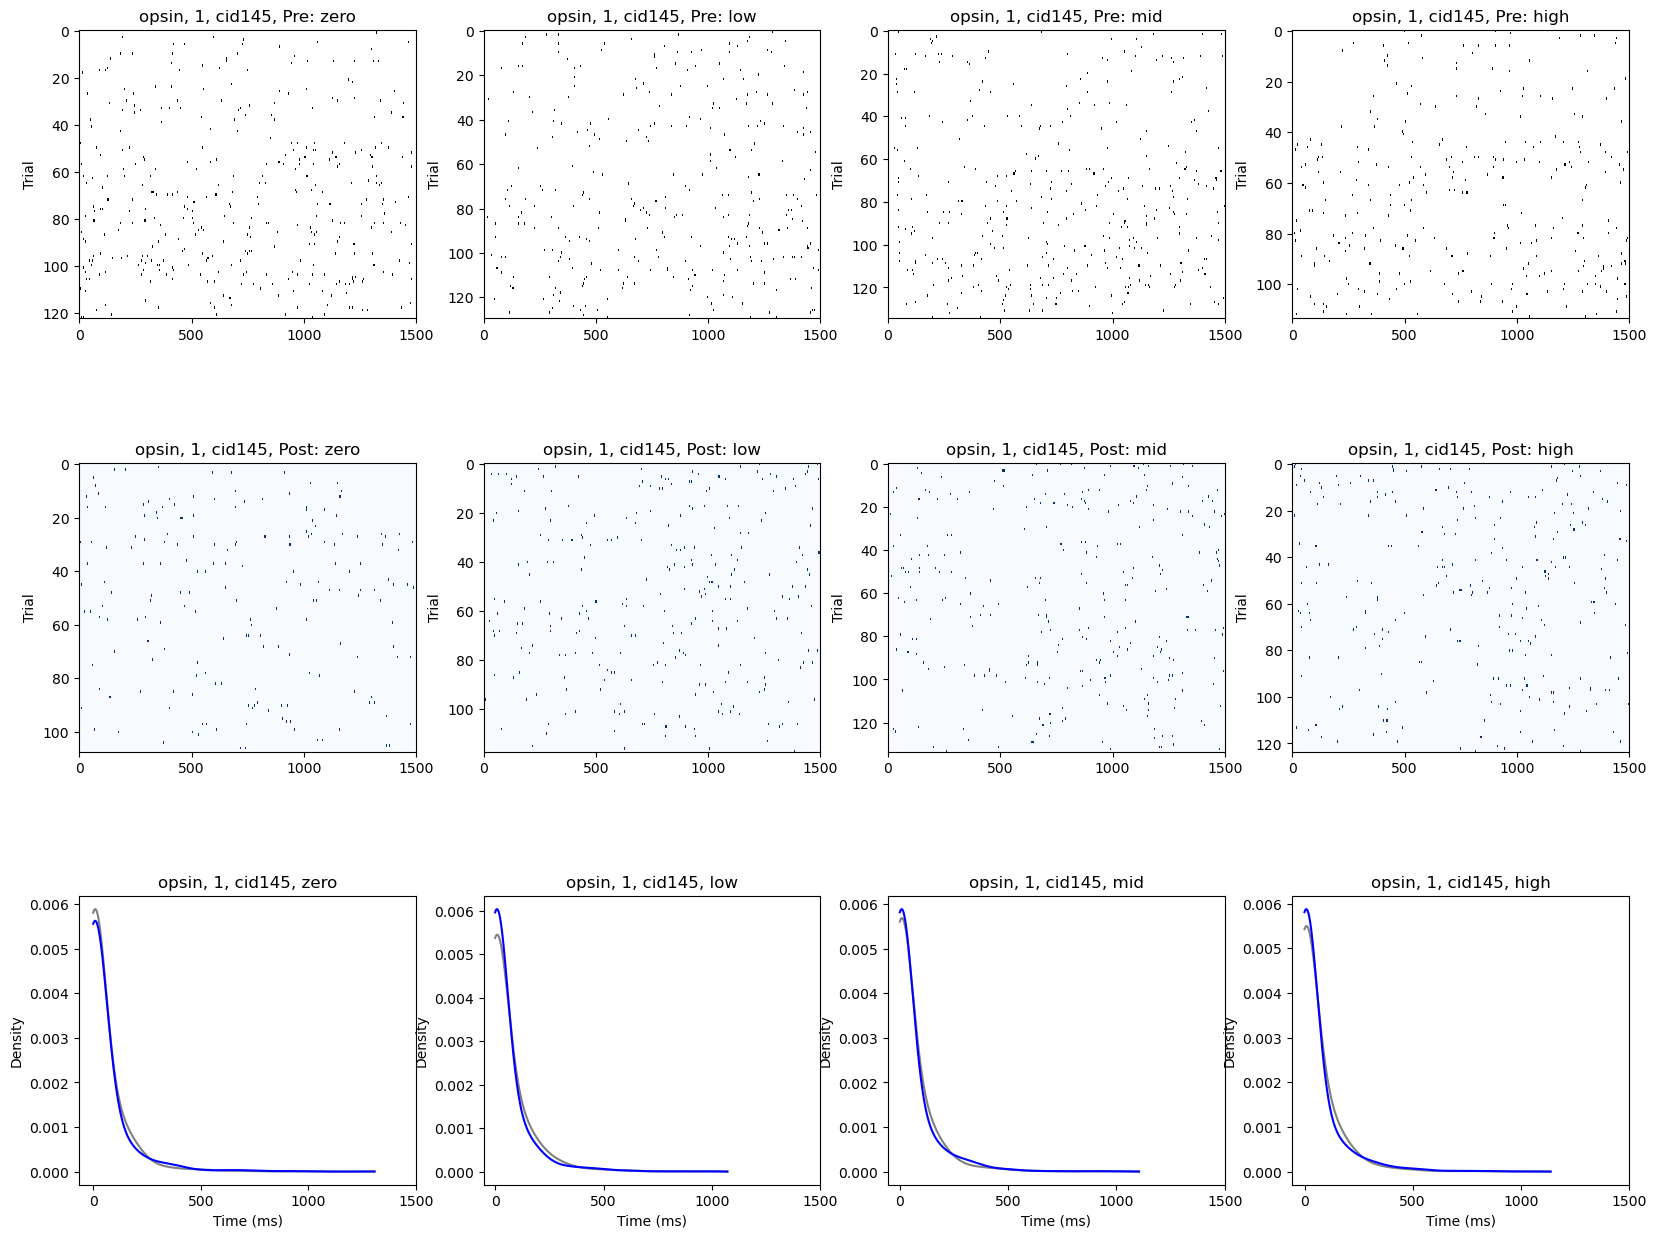

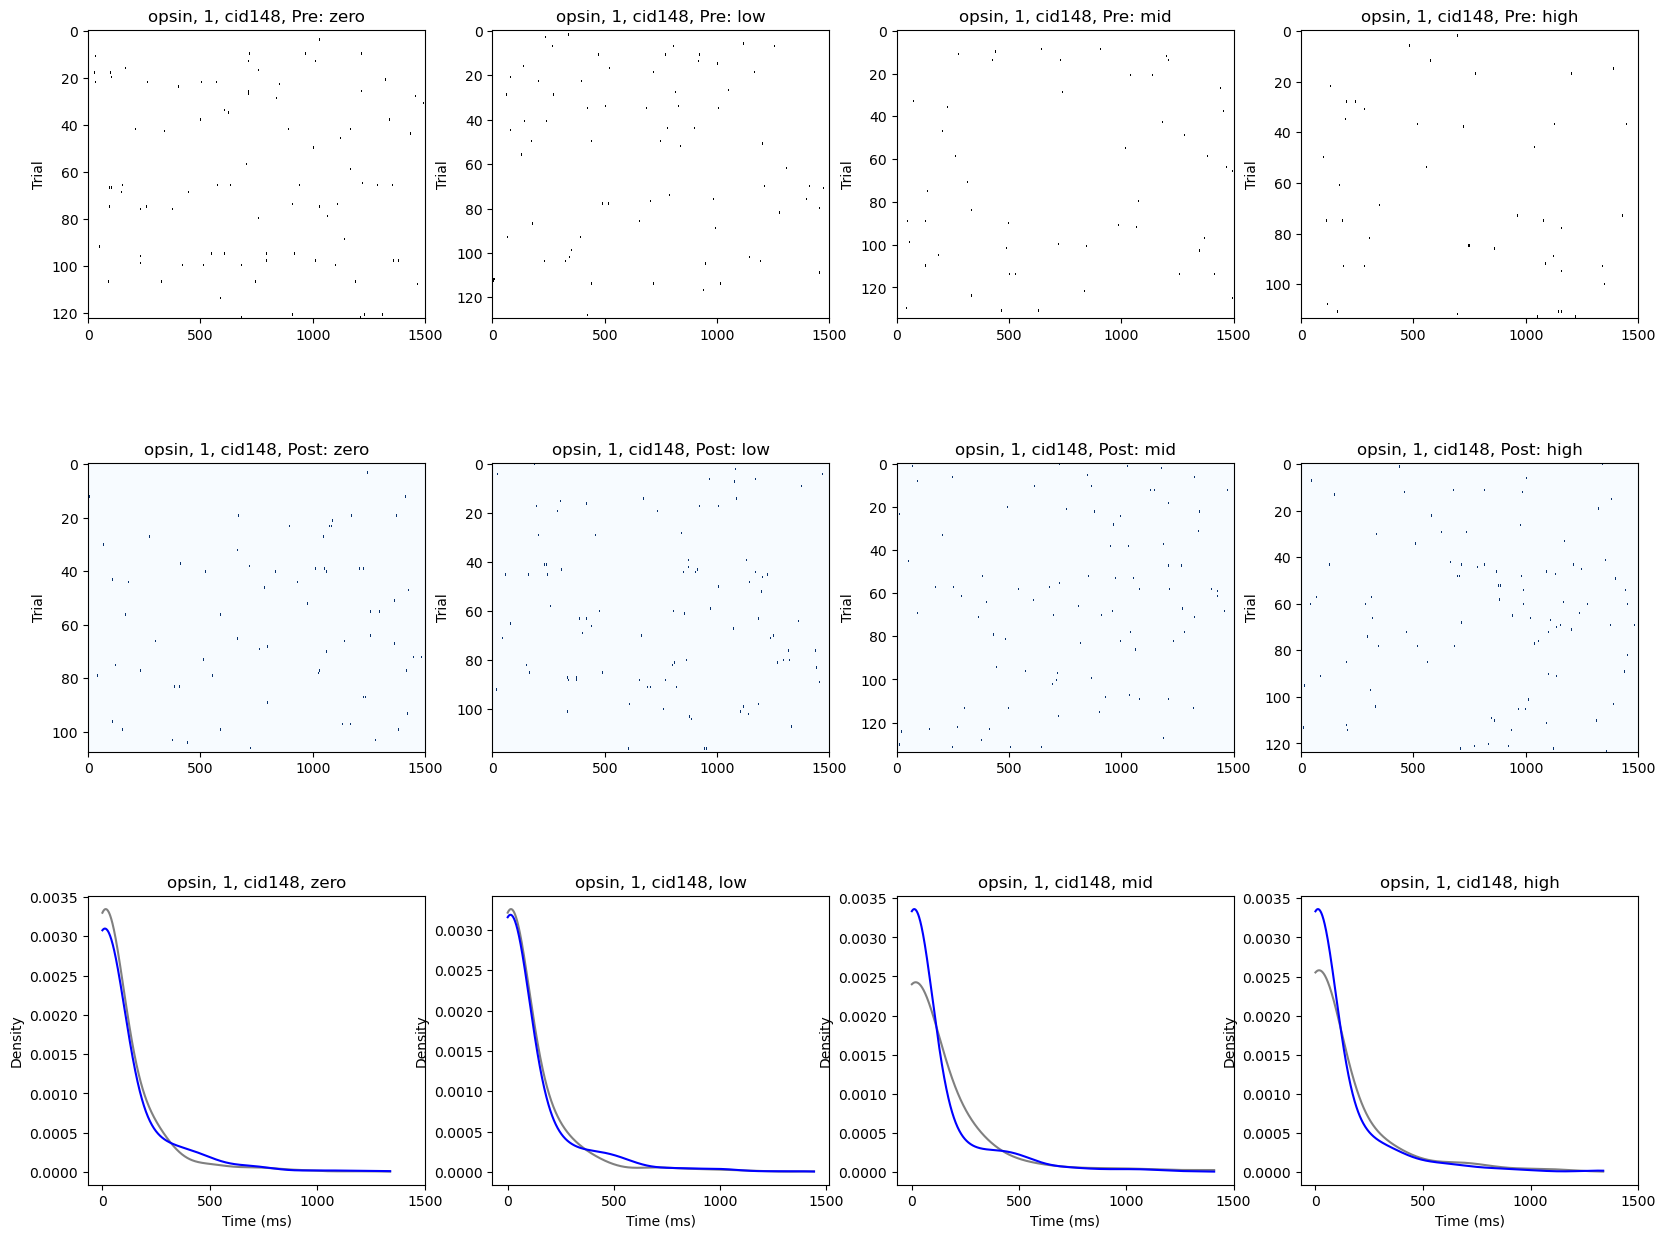

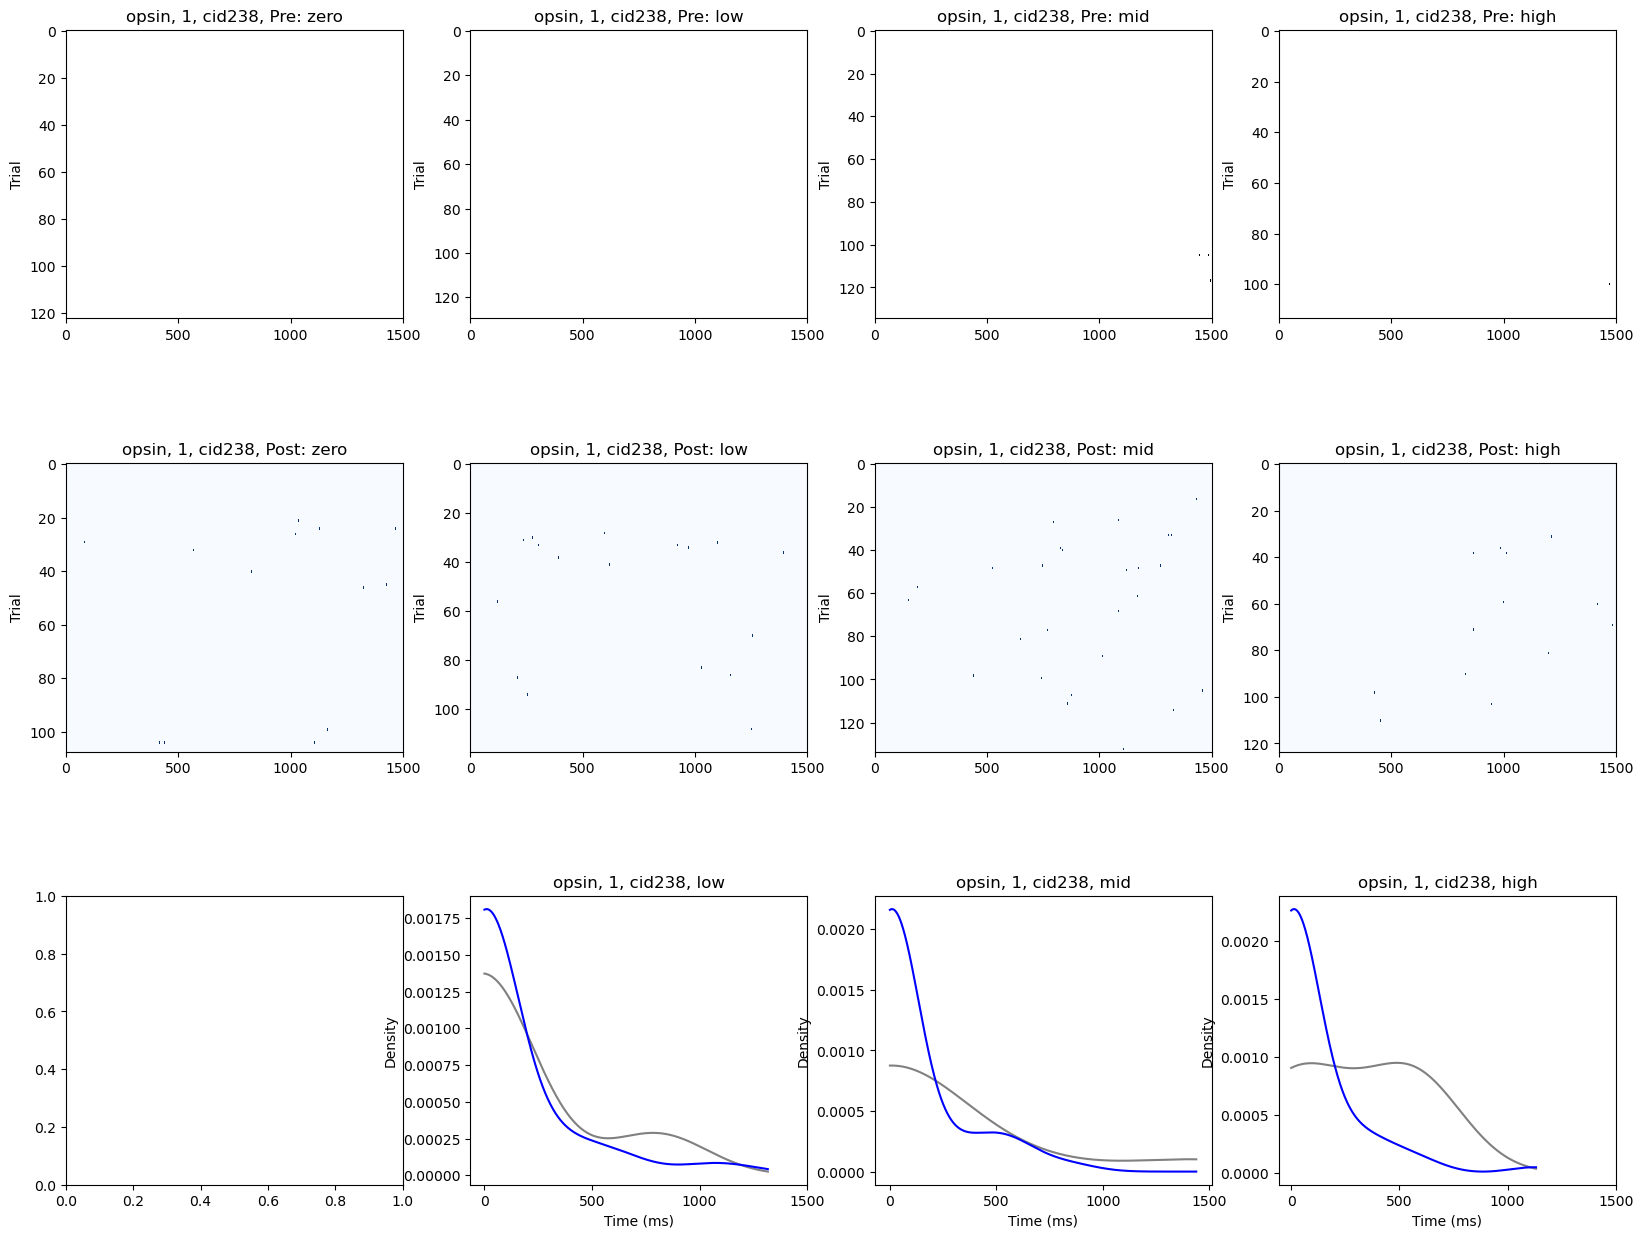

In [13]:
import matplotlib.pyplot as plt

# Define the function to generate combined raster plots and KDE plots with unfiltered data

def generate_combined_plots_unfiltered(cell_id):
    # Get the file names for the given cell ID
    file_names = df[df["cell_id"] == cell_id]["file_name"].tolist()

    # Set the colors for pre and post conditions
    colors = {"pre": "grey", "post": "blue"}

    # Get the mouse id from the file name
    mouse_id = file_names[0].split("_")[4]
    
    #get the group id from the file name
    group_id = file_names[0].split("_")[1]

    # Create a new figure
    fig, ax = plt.subplots(3, 4, figsize=(20, 15))

    # Iterate over the stimulation levels
    for i, stimulation_level in enumerate(["zero", "low", "mid", "high"]):
        # Find the file name for the current stimulation level and pre condition
        pre_file_name = next((file_name for file_name in file_names if stimulation_level in file_name and "pre" in file_name), None)
        # Find the file name for the current stimulation level and post condition
        post_file_name = next((file_name for file_name in file_names if stimulation_level in file_name and "post" in file_name), None)

        if pre_file_name is not None and post_file_name is not None:
            # Get the unfiltered spike data directly from the .npy files
            pre_spike_data = np.load(f"/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/{pre_file_name}")
            post_spike_data = np.load(f"/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/{post_file_name}")
            
            # Generate the raster plot for pre condition
            ax[0, i].imshow(pre_spike_data, aspect="auto", cmap="Greys", interpolation="nearest")
            ax[0, i].set_ylabel("Trial")
            ax[0, i].set_title(f"{group_id}, {mouse_id}, {cell_id}, Pre: {stimulation_level}")
            ax[0, i].set_xticks([0, 500, 1000, 1500])
            ax[0, i].set_xticklabels([0, 500, 1000, 1500])

            # Generate the raster plot for post condition
            ax[1, i].imshow(post_spike_data, aspect="auto", cmap="Blues", interpolation="nearest")
            ax[1, i].set_ylabel("Trial")
            ax[1, i].set_title(f"{group_id}, {mouse_id}, {cell_id}, Post: {stimulation_level}")
            ax[1, i].set_xticks([0, 500, 1000, 1500])
            ax[1, i].set_xticklabels([0, 500, 1000, 1500])

            # Generate the KDE plot
            # Calculate ISIs across all trials
            pre_ISIs = np.diff(np.where(pre_spike_data == 1), axis=1).flatten()
            post_ISIs = np.diff(np.where(post_spike_data == 1), axis=1).flatten()

            # Check if there are enough ISIs to calculate KDEs
            if len(pre_ISIs) > 0 and len(post_ISIs) > 0:
                # Calculate KDEs
                pre_kde = stats.gaussian_kde(pre_ISIs)
                post_kde = stats.gaussian_kde(post_ISIs)

                x = np.linspace(0, max(np.max(pre_ISIs), np.max(post_ISIs)), 1000)
                ax[2, i].plot(x, pre_kde(x), color="grey")
                ax[2, i].plot(x, post_kde(x), color="blue")
                ax[2, i].set_xlabel("Time (ms)")
                ax[2, i].set_ylabel("Density")
                ax[2, i].set_title(f"{group_id}, {mouse_id}, {cell_id}, {stimulation_level}")
                ax[2, i].set_xticks([0, 500, 1000, 1500])
                ax[2, i].set_xticklabels([0, 500, 1000, 1500])

    # Increase the vertical spacing
    plt.subplots_adjust(hspace=0.5)

    # Show the plots
    plt.show()
    
    #save the plots as a pdf
    fig.savefig(f"/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/{group_id}_{mouse_id}_{cell_id}.pdf")
  

# Generate the plots for all cell IDs
for cell_id in df["cell_id"].unique():
    generate_combined_plots_unfiltered(cell_id)
            


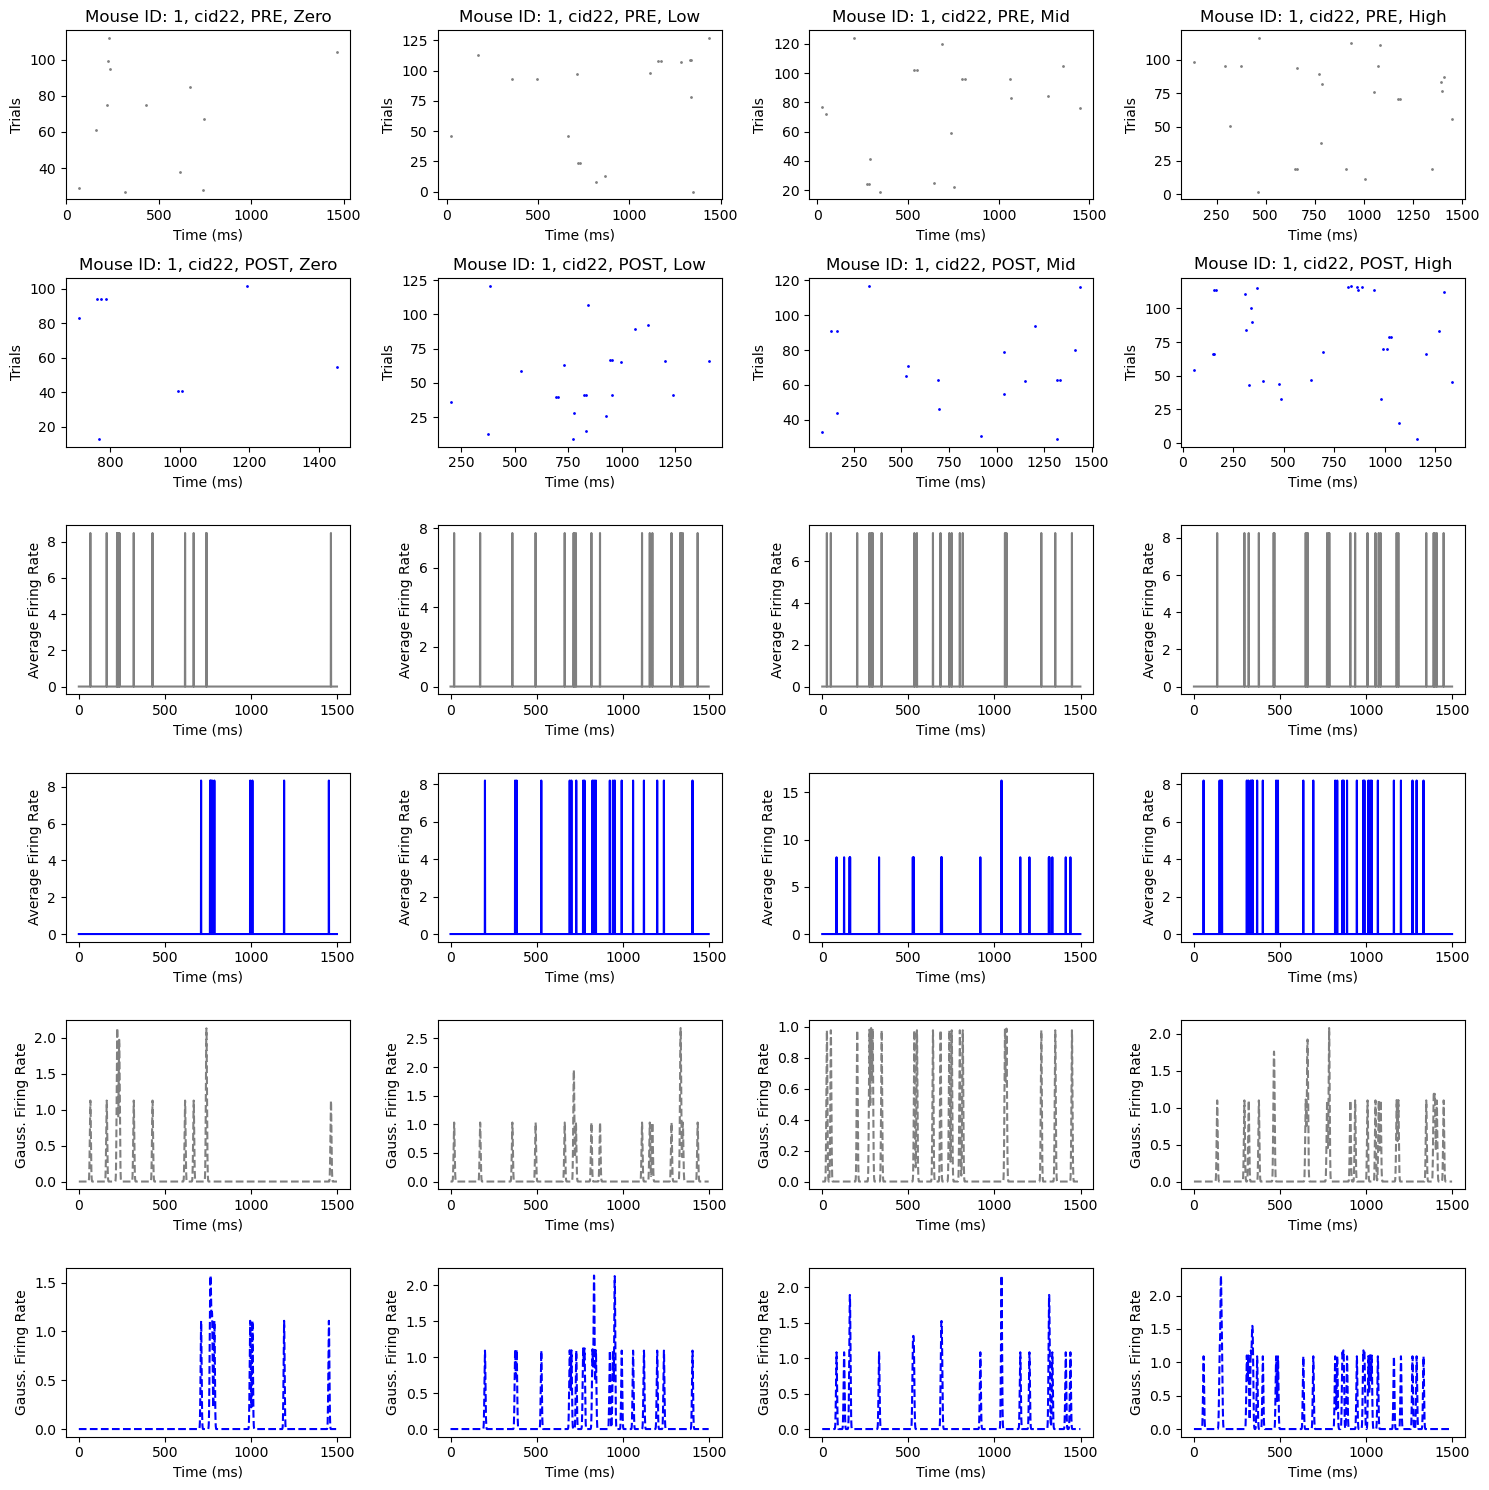

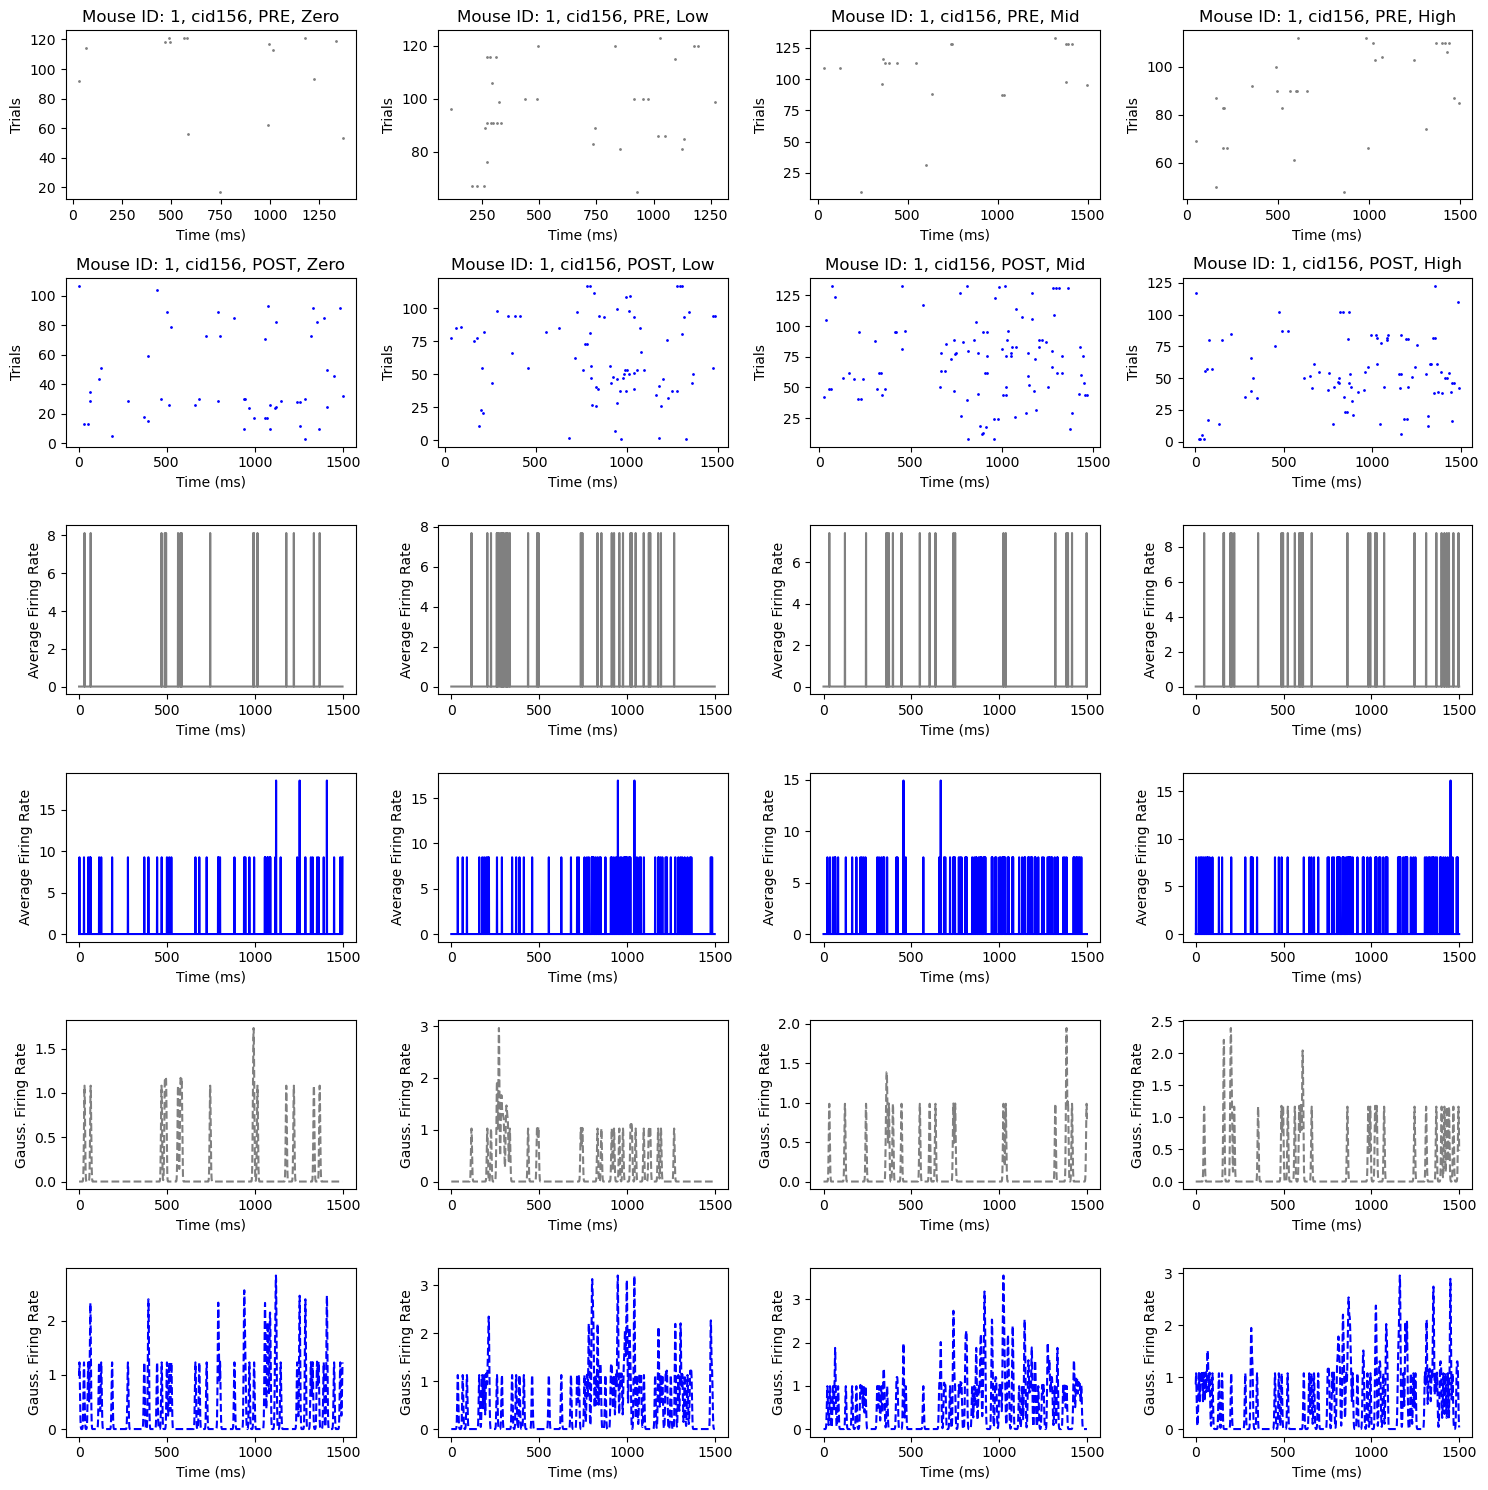

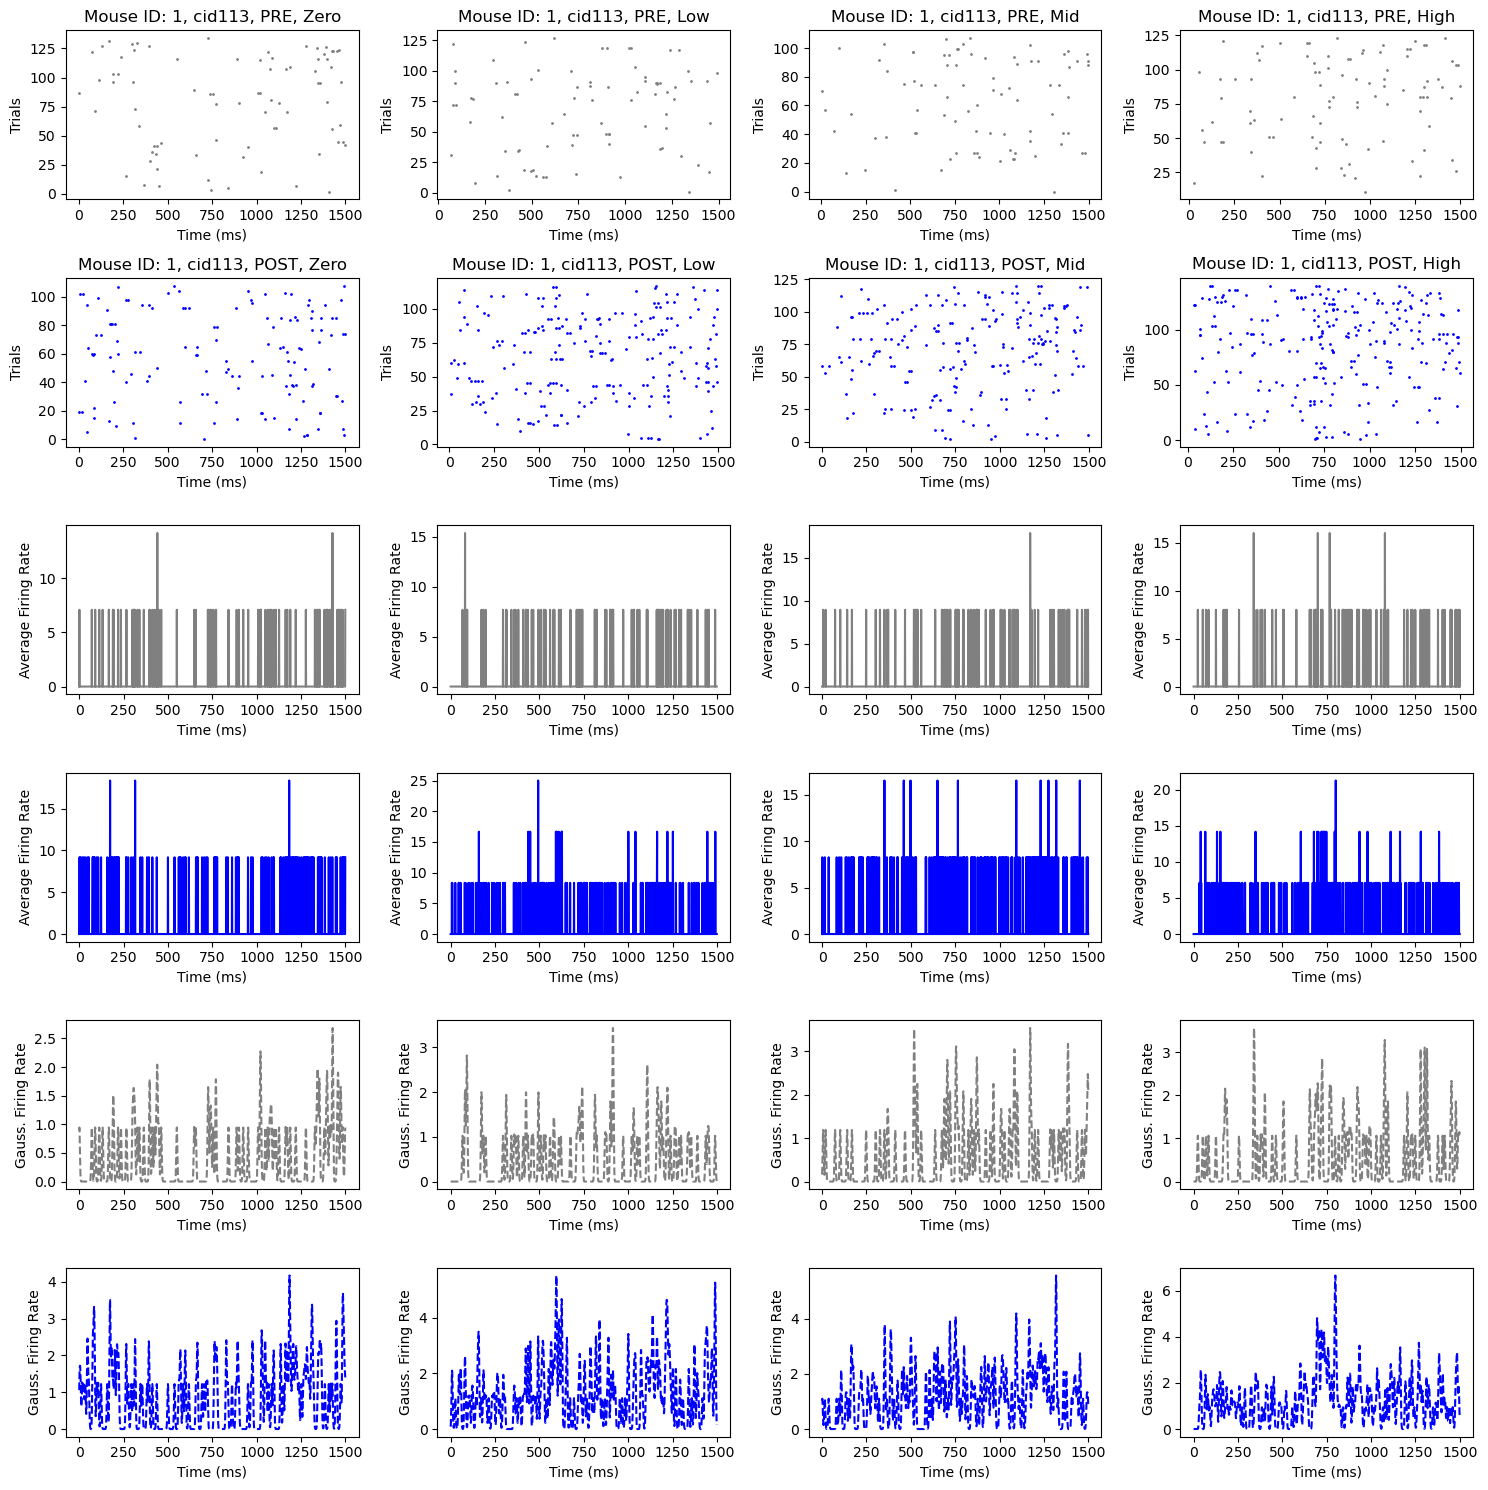

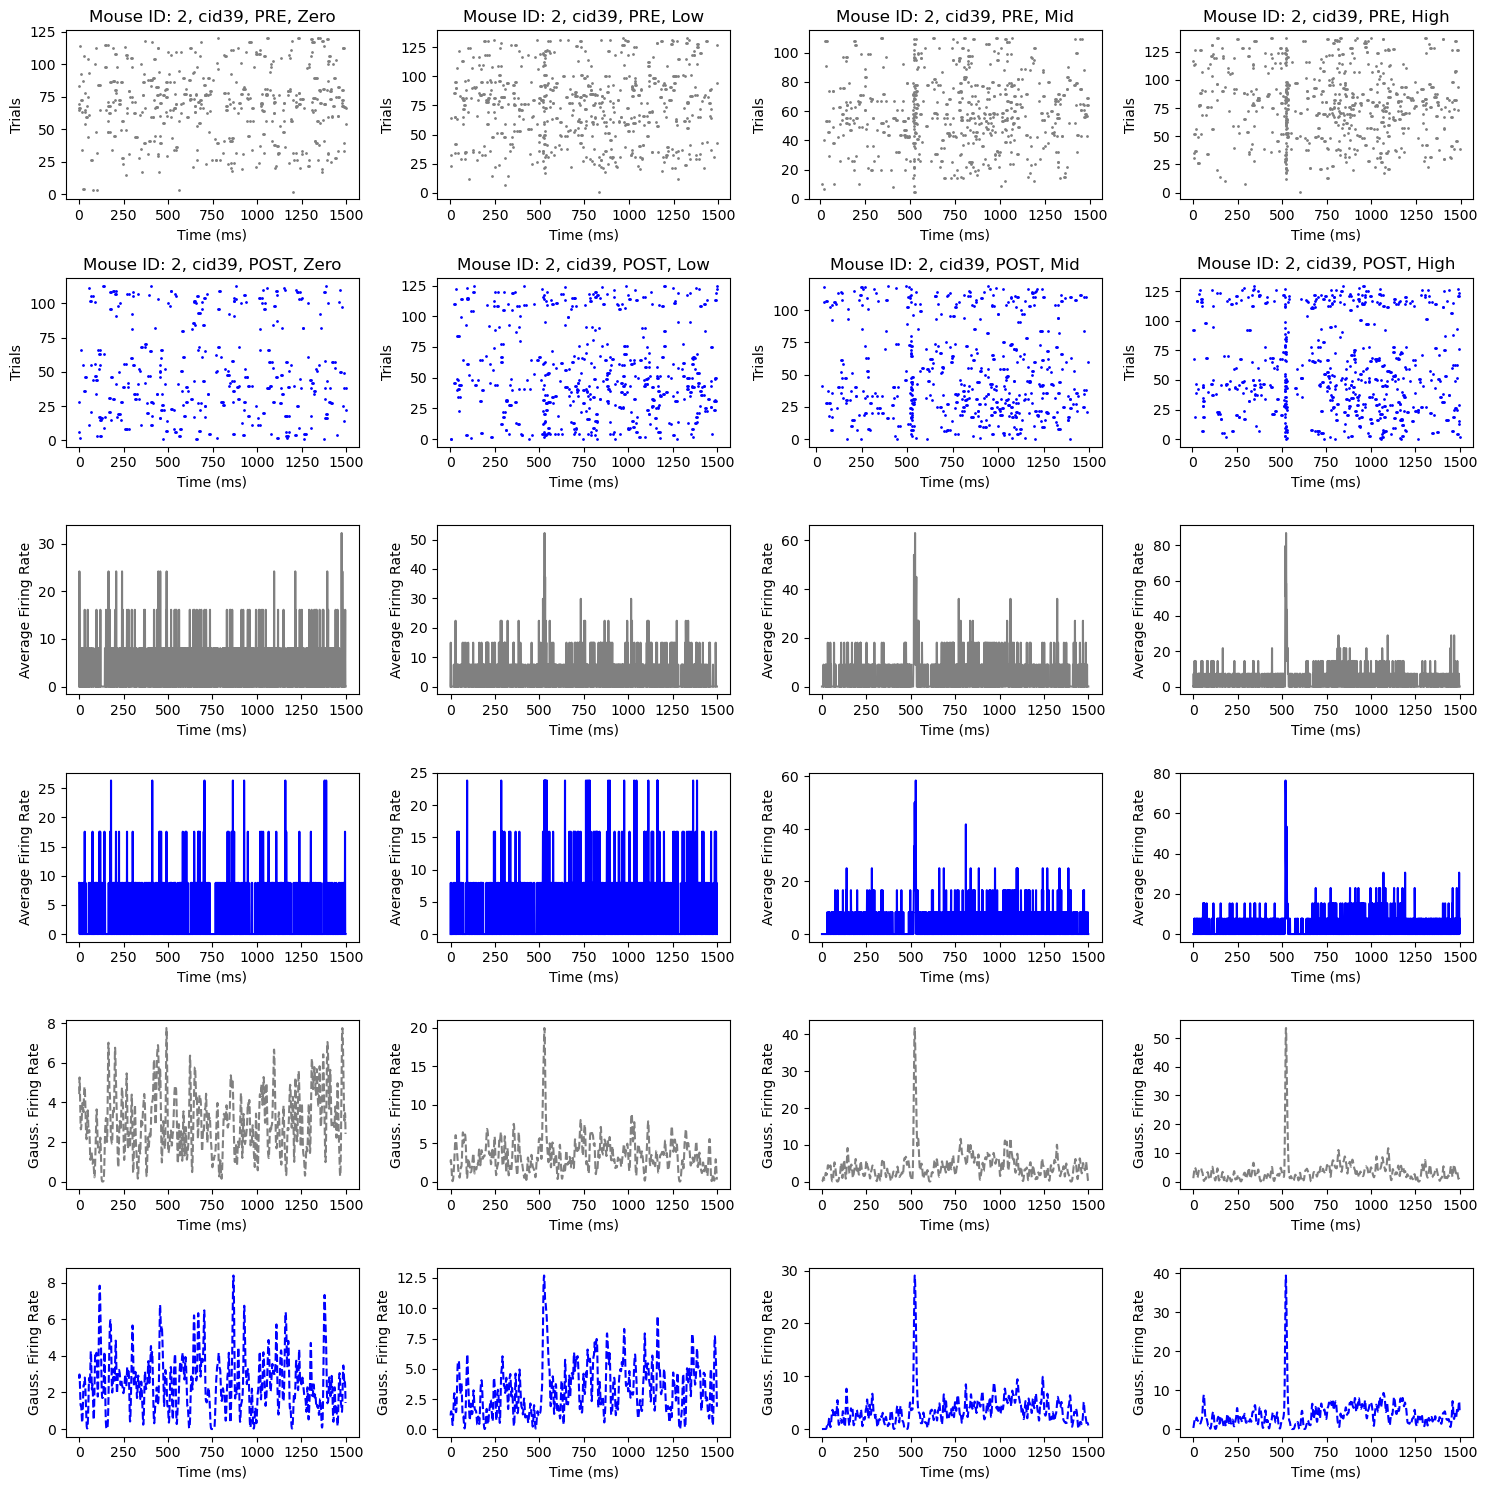

KeyboardInterrupt: 

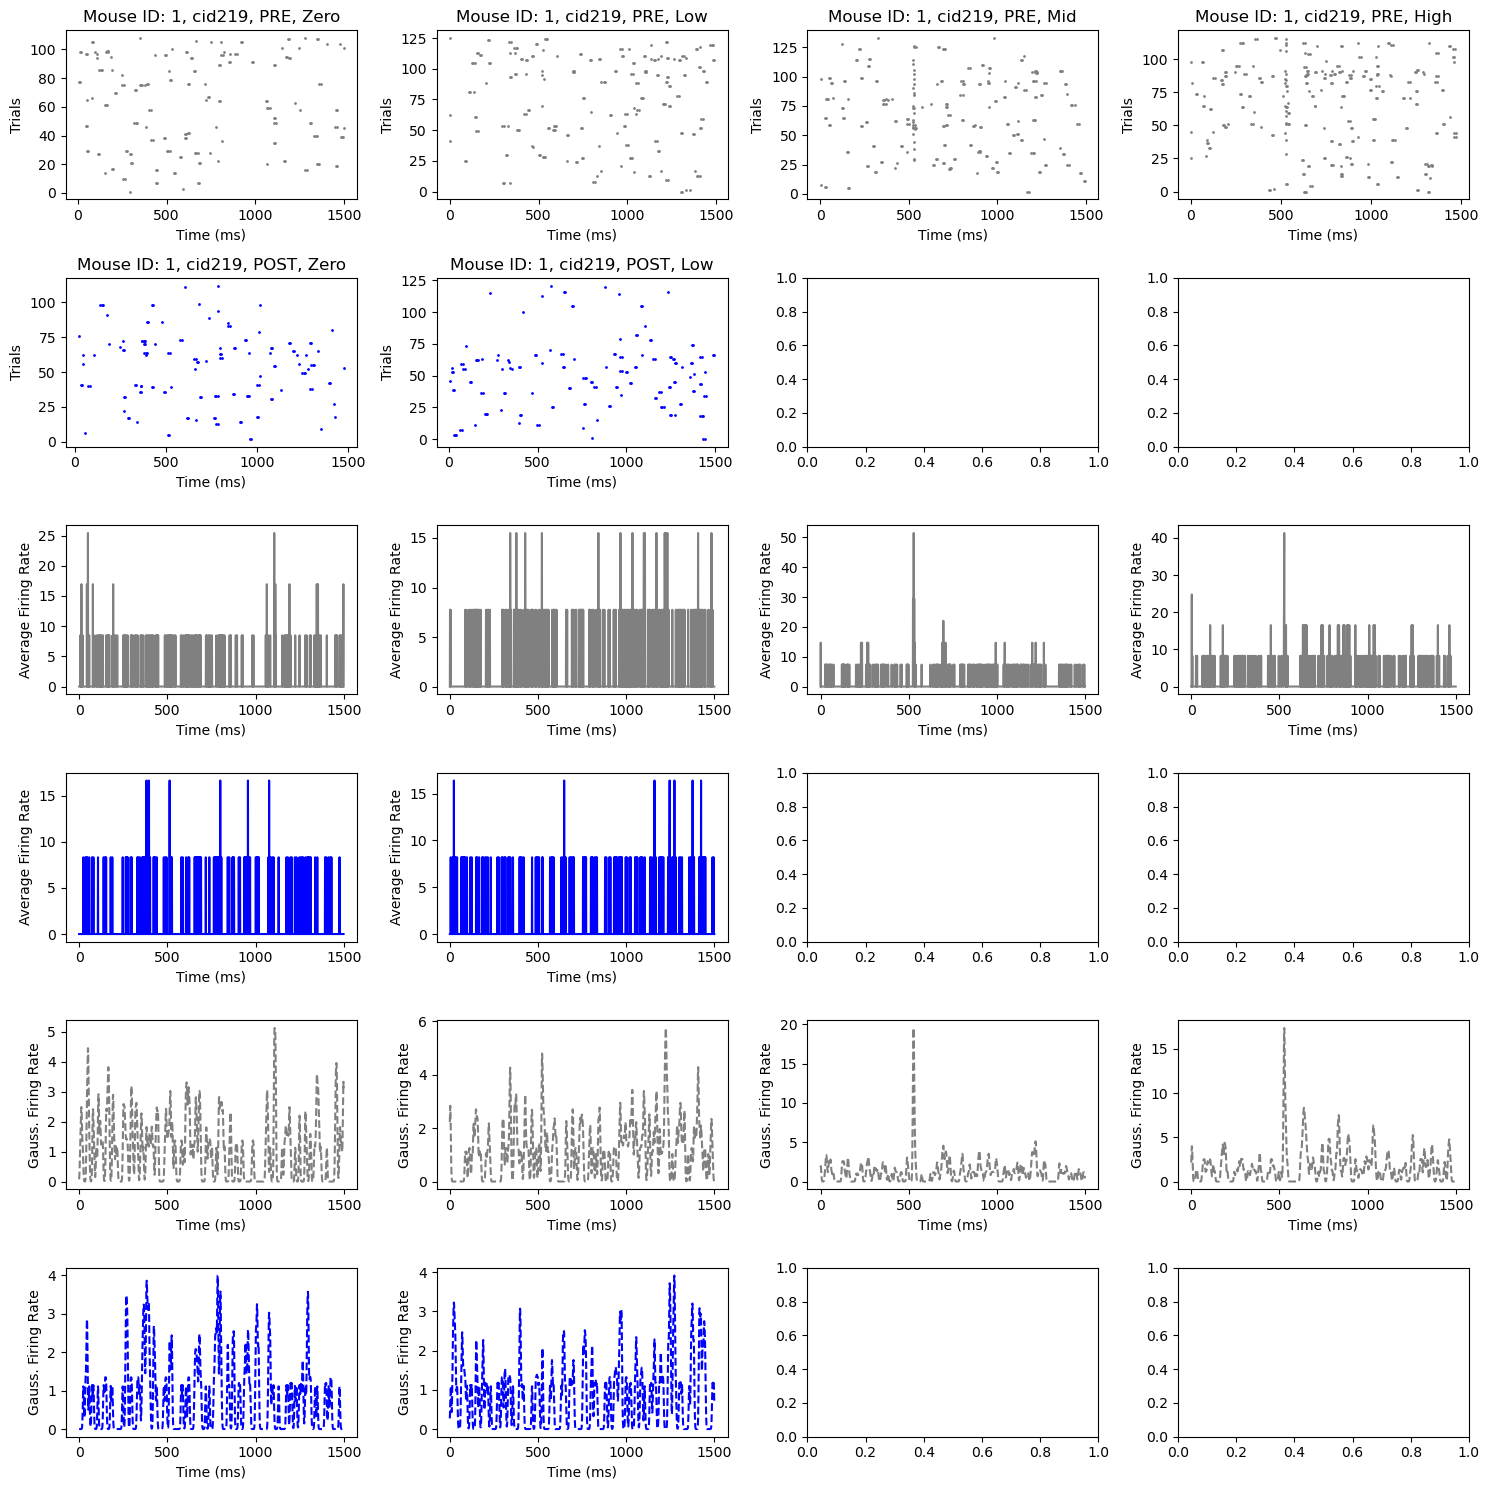

In [36]:
#now lets repeat the process as above but now we will caclulate and plot the PSTH for each cell in the dataframe

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def plot_spike_raster(spike_data, ax, color):
    """
    Plot spike raster.
    
    Parameters:
    spike_data (numpy.ndarray): 2D array of spike data (trials x time).
    ax (matplotlib.axes.Axes): Axes object to plot on.
    color (str): Color of the spikes.
    """
    for i in range(spike_data.shape[0]): #for each row in the array, which is each trial, plot the spike times
        spike_times = np.where(spike_data[i, :] == 1)[0] #find the indices where the value is 1, which is where the spike is
        ax.scatter(spike_times, i * np.ones_like(spike_times), color=color, s=1) #plot the spike times on the y axis, and the trial number on the x axis

def plot_spike_raster_avg(spike_data, ax, color):
    """
    Plot spike raster and average firing rate.
    
    Parameters:
    spike_data (numpy.ndarray): 2D array of spike data (trials x time).
    ax (matplotlib.axes.Axes): Axes object to plot on.
    color (str): Color of the spikes.
    """
    
    # Calculate and plot average firing rate
    avg_firing_rate = np.mean(spike_data, axis=0) #axis=0 means average across rows, axis=1 means average across columns
    
    # Plot average firing rate
    ax.plot(avg_firing_rate*1000, color=color) #multiply by 1000 to get the firing rate in Hz
    ax.set_ylabel('Average Firing Rate')
    ax.set_xlabel('Time (ms)')
    
def calculate_psth(spike_data, bin_size=1):
    """
    Calculate Peri-Stimulus Time Histogram (PSTH).
    
    Parameters:
    spike_data (numpy.ndarray): 2D array of spike data (trials x time).
    bin_size (int): Size of the bin in milliseconds.
    
    Returns:
    psth (numpy.ndarray): PSTH values.
    """
    # Count spikes in each bin
    binned_spikes = np.sum(spike_data, axis=0) #axis=0 means sum across rows, axis=1 means sum across columns
    
    # Number of trials
    num_trials = spike_data.shape[0]

    # Calculate PSTH
    psth = binned_spikes / (num_trials * bin_size) #divide by the number of trials and the bin size to get the firing rate

    return psth

def plot_psths(spike_data, ax, color):
    """
    Plot Peri-Stimulus Time Histograms (PSTHs), both raw and smoothed.
    
    Parameters:
    spike_data (numpy.ndarray): 2D array of spike data (trials x time).
    ax (matplotlib.axes.Axes): Axes object to plot on.
    color (str): Color of the PSTHs.
    """
    # Calculate PSTH
    psth = calculate_psth(spike_data)*1000 #multiply by 1000 to get the firing rate in Hz

    # Calculate and plot smoothed PSTH
    #construct a gaussian filter from scratch with a sigma of 3 and window size of 21
    #create the gaussian filter
    sigma = 3
    window_size = 21
    
    gaussian_filter = np.exp(-(np.arange(-(window_size // 2), window_size // 2 + 1) ** 2) / (2 * sigma ** 2)) #gaussian filter equation
    
    # Normalize the filter 
    gaussian_filter = gaussian_filter / np.sum(gaussian_filter) #divide the gaussian filter by the sum of the gaussian filter
    
    # Smooth the PSTH
    smoothed_psth = np.convolve(psth, gaussian_filter, mode='same') #convolve the PSTH with the gaussian filter to smooth it
    
    
    ax.plot(smoothed_psth, color=color, linestyle='--')
    ax.set_ylabel('Gauss. Firing Rate')
    ax.set_xlabel('Time (ms)')


# Define a function to generate combined plots
def generate_combined_plots_psth(cell_id):
    epochs = ["pre", "post"] #define the epochs pore and post CTZ
    stimulations = ["zero", "low", "mid", "high"] #define the stimulations zero, low, mid, and high 
    colors = ["grey", "blue"] #define the colors for the epochs, grey for pre and blue for post
    
    file_names = df[df["cell_id"] == cell_id]["file_name"].tolist() #get the file names for the given cell ID, which is the cell ID in the dataframe
    mouse_id = file_names[0].split("_")[4] #get the mouse id from the file name, which is the mouse ID in the dataframe
    
    fig, axs = plt.subplots(6, 4, figsize=(15, 15), tight_layout=True) #create a figure with 6 rows and 4 columns of subplots
    
    for i, epoch in enumerate(epochs): #for each row in the array, which is each trial, plot the spike times
        for j, stimulation in enumerate(stimulations): #for each row in the array, which is each trial, plot the spike times 
            file_name = next((file_name for file_name in file_names if stimulation in file_name and epoch in file_name), None)# Find the file name for the current stimulation level and epoch
            if file_name is not None: #if the file name is not none, then plot the data
                # Extract only the file name without directories
                file_name_only = file_name.split("/")[-1] # Split the path and keep the last part
                spike_data = np.load(f"/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/{file_name_only}") #load the spike data
                plot_spike_raster(spike_data, axs[i, j], colors[i]) #plot the spike raster
                axs[i, j].set_title(f"Mouse ID: {mouse_id}, {cell_id}, {epoch.upper()}, {stimulation.capitalize()}")
                axs[i, j].set_xlabel('Time (ms)')
                axs[i, j].set_ylabel('Trials')
                
                plot_spike_raster_avg(spike_data, axs[2 + i, j], colors[i]) #plot the spike raster average
                plot_psths(spike_data, axs[4 + i, j], colors[i]) #plot the PSTH
                #axs[2 + i, j].set_xlabel('Time (ms)')
                #axs[2 + i, j].set_ylabel('PSTH')

    plt.show()
        
    #save the plots as a pdf
    fig.savefig(f"/Users/cresp1el/Documents/lmc_project_analysis_dir/analysis_directory/psths1/{group_id}_{mouse_id}_{cell_id}.pdf")

# Generate the plots for all cell IDs
for cell_id in df["cell_id"].unique():
    generate_combined_plots_psth(cell_id)

In [23]:
df["cell_id"].unique()[2]

'cid156'